In [106]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
import os
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import statsmodels.api as sm
import pylab
import random
import xgboost as xgb
warnings.filterwarnings('ignore')

### Step 1: Data Download and Preparation

In [107]:
def download_and_save_data(tickers, start_date, end_date, save_dir="stock_data"):
    os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist
    data = {}

    for ticker in tickers:
        file_path = os.path.join(save_dir, f"{ticker}.csv")
        
        # Check if the file exists and load it
        if os.path.exists(file_path):
            stock_data = pd.read_csv(file_path, index_col="Date", parse_dates=True)
        else:
            stock_data = yf.download(ticker, start=start_date, end=end_date)
            stock_data = stock_data.reset_index()
            stock_data["Date"] = stock_data.Date.apply(lambda x: x.date())
            stock_data.set_index("Date", drop = True, inplace = True)
            stock_data.to_csv(file_path)  # Save to file
        data[ticker] = stock_data

    return data

def preprocess_data(data):
    all_data = []
    for ticker, df in data.items():
        df['Ticker'] = ticker
        df['Date'] = df.index
        all_data.append(df)
    
    combined_data = pd.concat(all_data)
    combined_data.reset_index(drop=True, inplace=True)
    return combined_data

In [108]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Read the tables from the Wikipedia page
tables = pd.read_html(url)

# The first table on the page contains the S&P 500 companies
sp500_table = tables[0]

# Create a dictionary with Ticker symbols as keys and GICS Sector as values
ticker_sector_dict = pd.Series(sp500_table['GICS Sector'].values, index=sp500_table['Symbol']).to_dict()

In [109]:
#Experiment on a subset of stocks
# tickers = [
#     "AAPL", "NVDA", "MSFT", "AMZN", "META", "GOOGL", "AVGO", "TSLA", "UNH",
#     "JNJ", "V", "PG", "LLY", "JPM", "XOM", "MA", "HD", "CVX", "MCD",
#     "PFE", "PEP", "KO", "DIS", "INTC", "CSCO", "MRK", "NKE", "VZ", "T",
#     "WFC", "ABBV", "ORCL", "TMO", "CRM", "ACN", "ADBE", "CMCSA", "MS", "UPS",
#     "MDT", "HON", "PM", "UNP", "BMY", "QCOM", "TXN", "IBM", "C", "RTX"
# ]

# All the stocks
tickers = ticker_sector_dict.keys()

start_date = '2006-01-01'
end_date = '2019-12-31'
data = download_and_save_data(tickers, start_date, end_date)

In [110]:
data = {key: value for key, value in data.items() if len(value) >= 1500}

In [111]:
combined_data = preprocess_data(data)

In [112]:
combined_data

Open        High         Low       Close   Adj Close   Volume  \
0         65.016724   66.346153   64.581940   66.145485   37.646137  3728171   
1         66.463211   66.463211   65.426422   65.811035   37.455784  3059368   
2         65.560204   65.760872   64.849495   65.209030   37.113148  3025282   
3         65.752510   65.969902   64.916389   65.744148   37.417721  2965482   
4         65.635452   66.747490   65.602005   66.070236   37.603310  2207338   
...             ...         ...         ...         ...         ...      ...   
1571176  132.710007  133.059998  131.389999  132.369995  127.503952  1632300   
1571177  132.210007  133.080002  131.289993  132.919998  128.033722   442500   
1571178  133.190002  133.190002  132.320007  133.029999  128.139664   929400   
1571179  133.399994  133.479996  132.380005  133.250000  128.351562  1296100   
1571180  133.570007  133.660004  131.809998  132.210007  127.349854   942000   

        Ticker       Date  
0          MMM 2006-01-03  
1          MMM 2006-01-04  
2          MMM 2006-01-05  
3          MMM 2006-01-06  
4          MMM 2006-01-09  
...        ...        ...  
1571176    ZTS 2019-12-23  
1571177    ZTS 2019-12-24  
1571178    ZTS 2019-12-26  
1571179    ZTS 2019-12-27  
1571180    ZTS 2019-12-30  

[1571181 rows x 8 columns]

In [113]:
combined_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Ticker       0
Date         0
dtype: int64

In [114]:
combined_data.describe()

Open          High           Low         Close     Adj Close  \
count  1.571181e+06  1.571181e+06  1.571181e+06  1.571181e+06  1.571181e+06   
mean   6.416964e+01  6.484563e+01  6.347642e+01  6.418376e+01  5.376535e+01   
std    1.091160e+02  1.102937e+02  1.079467e+02  1.091586e+02  1.057501e+02   
min    1.500000e-01  1.595000e-01  1.437500e-01  1.475000e-01  1.352700e-01   
25%    2.473591e+01  2.504000e+01  2.441000e+01  2.474000e+01  1.835143e+01   
50%    4.382000e+01  4.430000e+01  4.332000e+01  4.382333e+01  3.350330e+01   
75%    7.419000e+01  7.492000e+01  7.345000e+01  7.422000e+01  5.973796e+01   
max    3.900000e+03  3.946500e+03  3.815500e+03  3.892890e+03  3.892890e+03   

             Volume  
count  1.571181e+06  
mean   8.688413e+06  
std    4.654289e+07  
min    0.000000e+00  
25%    1.046700e+06  
50%    2.386524e+06  
75%    5.578686e+06  
max    3.692928e+09

In [115]:
combined_data = combined_data.set_index("Date").sort_index()

In [116]:
combined_data.reset_index(inplace=True)
combined_data["Date"] = pd.to_datetime(combined_data.Date)
combined_data.set_index("Date", inplace = True)

In [117]:
train = combined_data.loc[combined_data.index<"2016"]
test = combined_data.loc[combined_data.index>="2016"]
train_size = train.groupby("Ticker").size().to_dict()
test_size = test.groupby("Ticker").size().to_dict()

In [118]:
train_size.values()

dict_values([2517, 2517, 756, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 534, 2517, 914, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 1198, 1036, 2517, 2517, 2517, 1613, 2517, 1938, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2212, 2517, 2517, 2517, 2148, 2517, 2517, 2517, 2517, 2517, 2517, 1398, 2517, 2517, 2517, 2517, 634, 2517, 2517, 2517, 2517, 1509, 2517, 2517, 2517, 2517, 2517, 2517, 2501, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 1270, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2183, 2517, 2517, 2517, 2154, 1543, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 945, 2517, 981, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 2517, 251

### Step2: Data Exploration and Preprocessing

In [119]:
# fig, axes = plt.subplots(3, 3, figsize=(16, 16))

# # Flatten the axes array for easier indexing
# axes = axes.flatten()

# # Loop through the first 12 tickers and create scatter plots
# i = 0
# for ticker in train.Ticker.unique()[:9]:
    
#     ticker_data = train.loc[train.Ticker == ticker]
#     Q1 = ticker_data.Volume.quantile(0.25)
#     Q3 = ticker_data.Volume.quantile(0.75)

#     IQR = Q3 - Q1

#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    
#     outlier_ratio = len(ticker_data[(ticker_data.Volume<lower_bound)|(ticker_data.Volume>upper_bound)])/len(ticker_data)
    
#     print("Outlier Ratio of "+ticker, outlier_ratio)
    
#     sns.boxplot(x="Volume", data= ticker_data, ax=axes[i])
#     axes[i].set_title(f'Volume for {ticker}')  # Add title for each subplot
#     i += 1

# plt.tight_layout()  # To avoid overlap between subplots
# plt.show()

In [120]:
# for col in train.drop("Ticker", axis = 1).columns:
    
#     for ticker in train.Ticker.unique():
    
#         ticker_data = train.loc[train.Ticker == ticker]
#         Q1 = ticker_data[col].quantile(0.25)
#         Q3 = ticker_data[col].quantile(0.75)

#         IQR = Q3 - Q1

#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
        
#         train.loc[(train[col]<lower_bound)&(train.Ticker == ticker), col] = lower_bound
#         train.loc[(train[col]>upper_bound)&(train.Ticker == ticker), col] = upper_bound

In [121]:
#Deal with Outliers
for col in train.drop("Ticker", axis = 1).columns:
    
    for ticker in train.Ticker.unique():
        
    
        ticker_data = train.loc[train.Ticker == ticker]
        ticker_trend = ticker_data.rolling(window=60, min_periods=1).mean()
        residual = ticker_data-ticker_trend

        Q1 = residual[col].quantile(0.25)
        Q3 = residual[col].quantile(0.75)

        IQR = Q3 - Q1

        lower_bound = Q1 - IQR
        upper_bound = Q3 + IQR

        outlier_ratio = len(residual[(residual[col]<lower_bound)|(residual[col]>upper_bound)])/len(residual)

#         print("Outlier Ratio of "+ticker+"_"+col, outlier_ratio)

        residual.loc[residual[col]<lower_bound, col] = lower_bound
        residual.loc[residual[col]>upper_bound, col] = upper_bound

        train.loc[(train.Ticker == ticker), col] = residual[col]+ticker_trend[col]

In [17]:
#Compute the target variable
train["Dollar_Volume"] = train["Close"]*train["Volume"]
test["Dollar_Volume"] = test["Close"]*test["Volume"]

In [18]:
# Take log transformation because the original data is very skewed
for df in [train, test]:
    for col in train.drop("Ticker", axis = 1).columns:
        df[col] = np.log1p(df[col])

In [19]:
#Standardize each stock
#This may take some time, like 10 mins
for ticker in train.Ticker.unique():
    for col in train.drop("Ticker", axis = 1).columns:
        scaler = StandardScaler()
        train.loc[train.Ticker==ticker, col] = scaler.fit_transform(train.loc[train.Ticker==ticker, col].values.reshape(-1,1))
        test.loc[test.Ticker==ticker, col] = scaler.transform(test.loc[test.Ticker==ticker, col].values.reshape(-1,1))

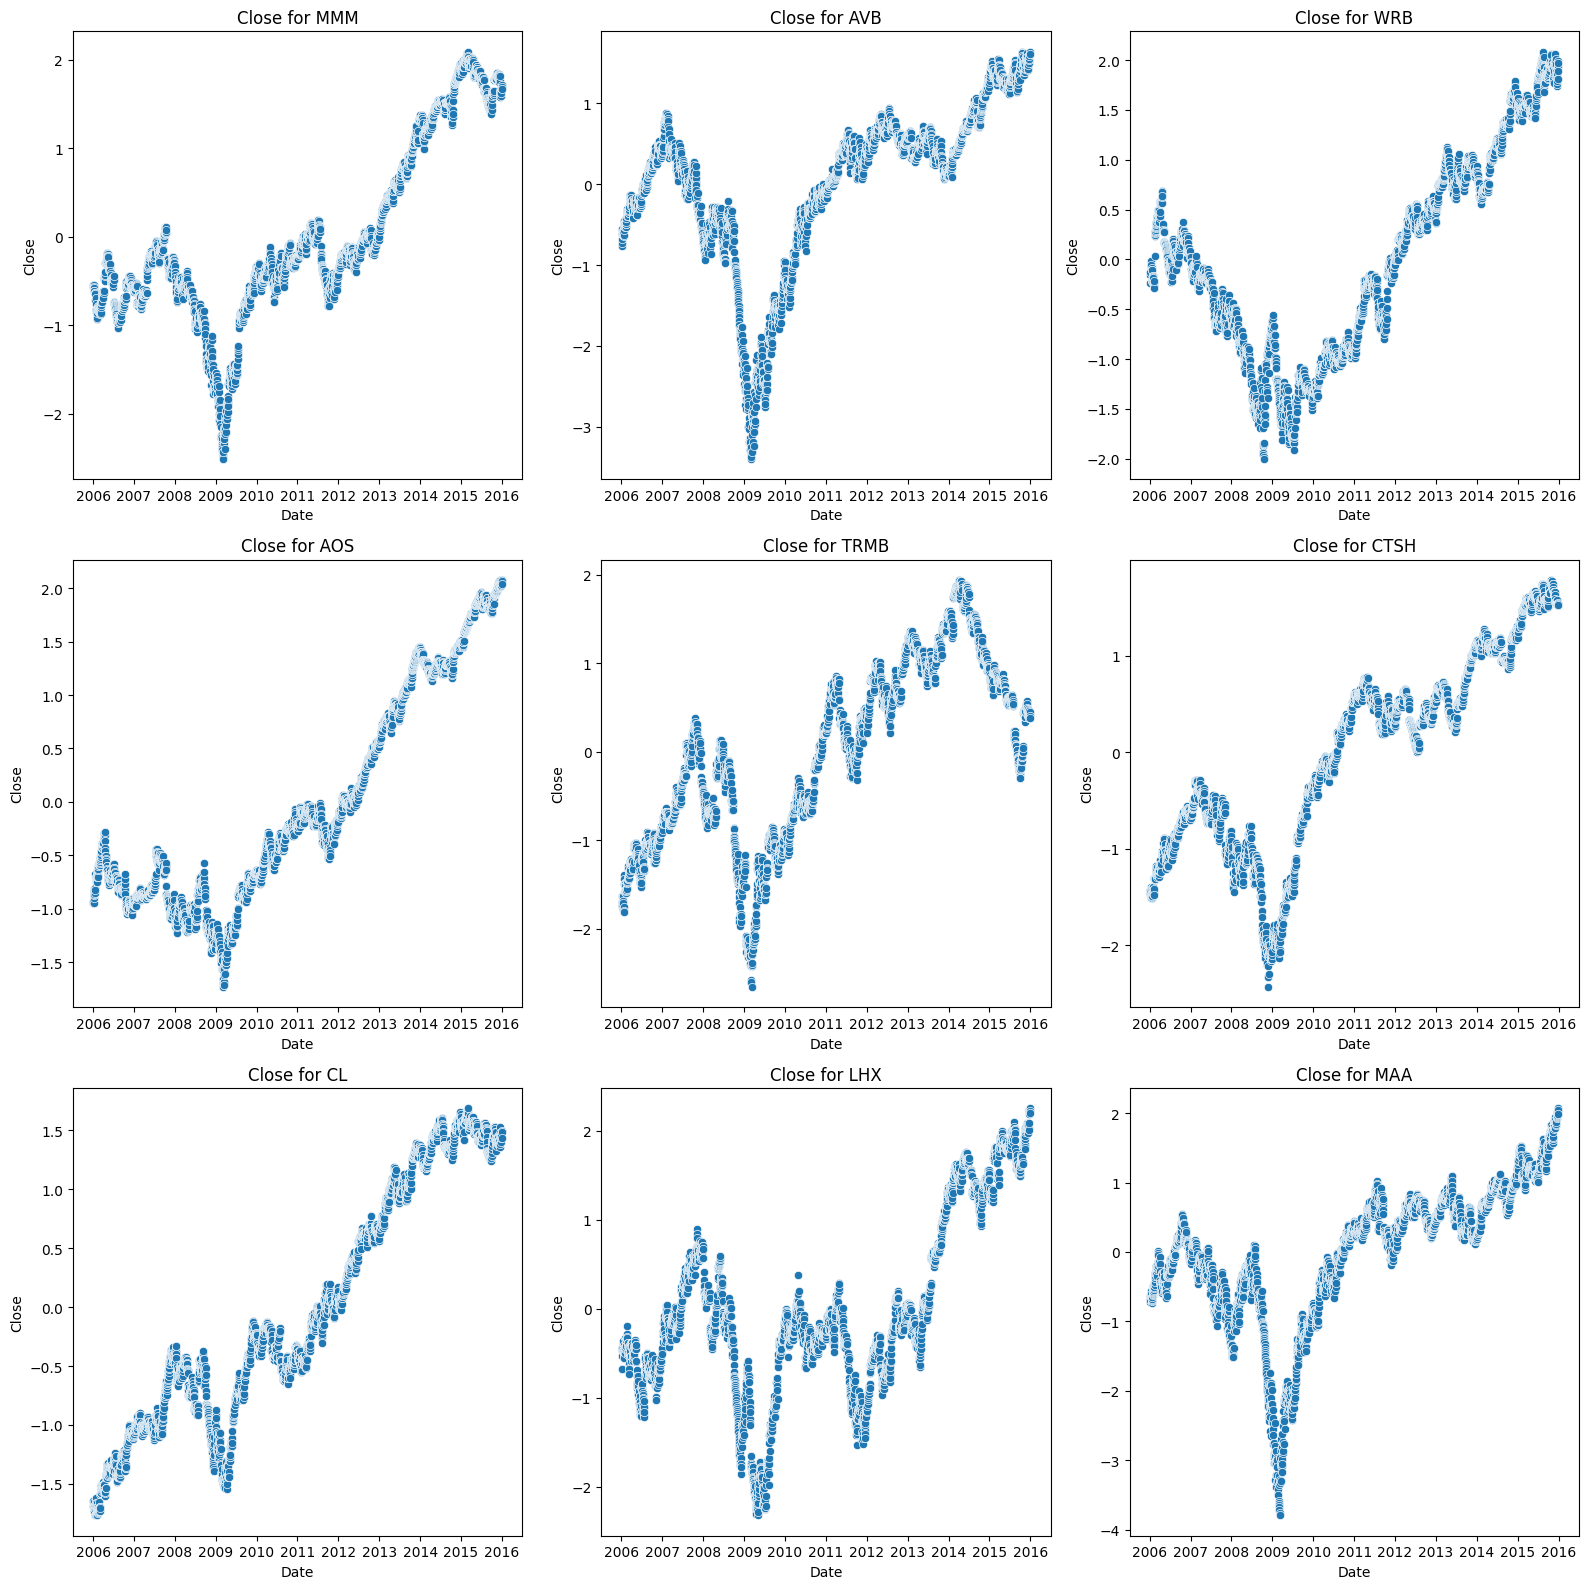

In [20]:
#Visualize the stock price
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through the first 12 tickers and create scatter plots
i = 0
for ticker in train.Ticker.unique()[:9]:
    sns.scatterplot(x="Date", y="Close", data=train.loc[train.Ticker == ticker], ax=axes[i])
    axes[i].set_title(f'Close for {ticker}')  # Add title for each subplot
    i += 1

plt.tight_layout()  # To avoid overlap between subplots
plt.show()

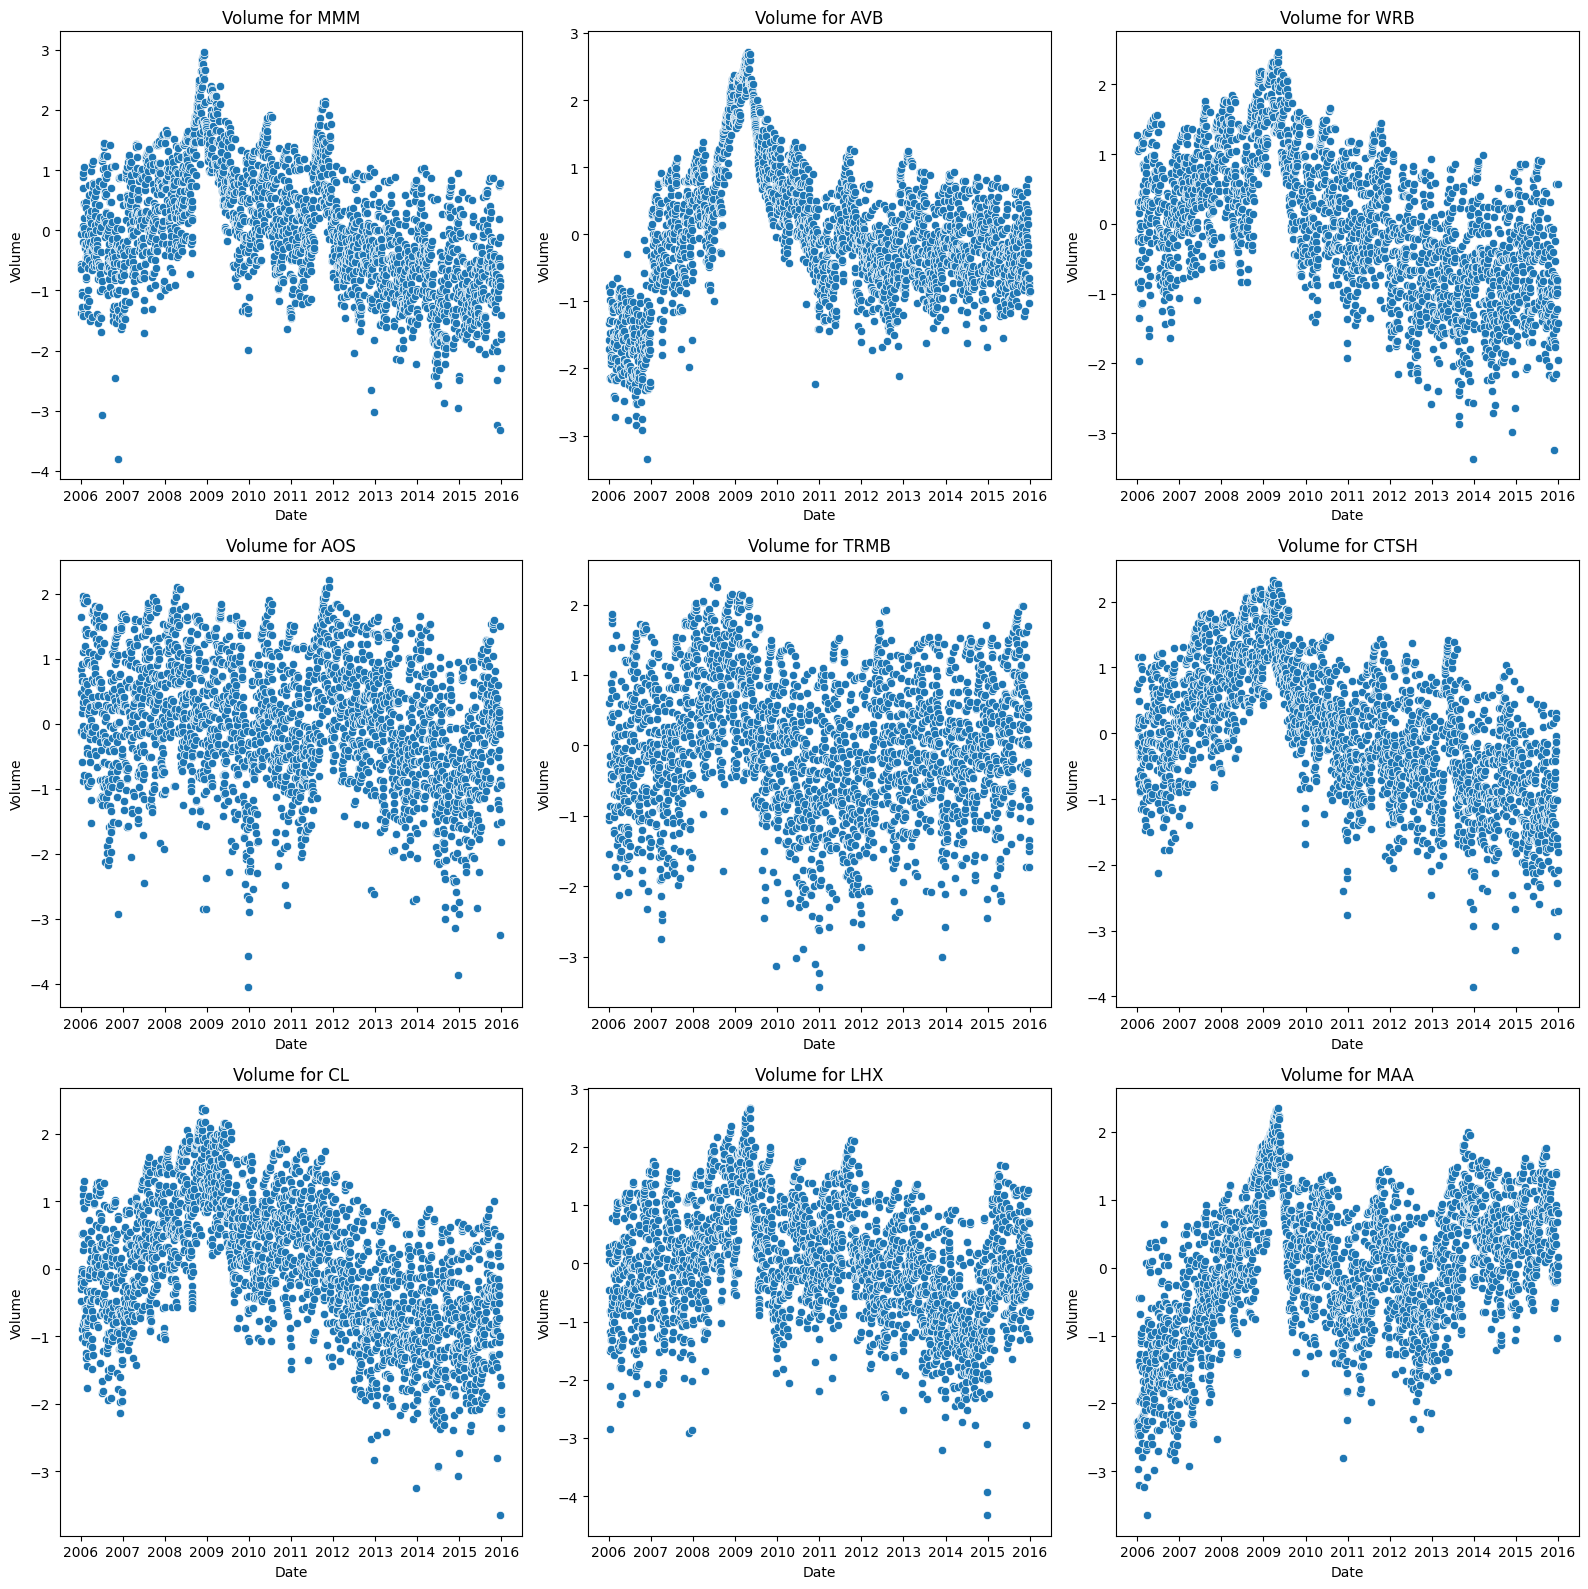

In [21]:
#Visualize the Volume
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through the first 12 tickers and create scatter plots
i = 0
for ticker in train.Ticker.unique()[:9]:
    sns.scatterplot(x="Date", y="Volume", data=train.loc[train.Ticker == ticker], ax=axes[i])
    axes[i].set_title(f'Volume for {ticker}')  # Add title for each subplot
    i += 1

plt.tight_layout()  # To avoid overlap between subplots
plt.show()

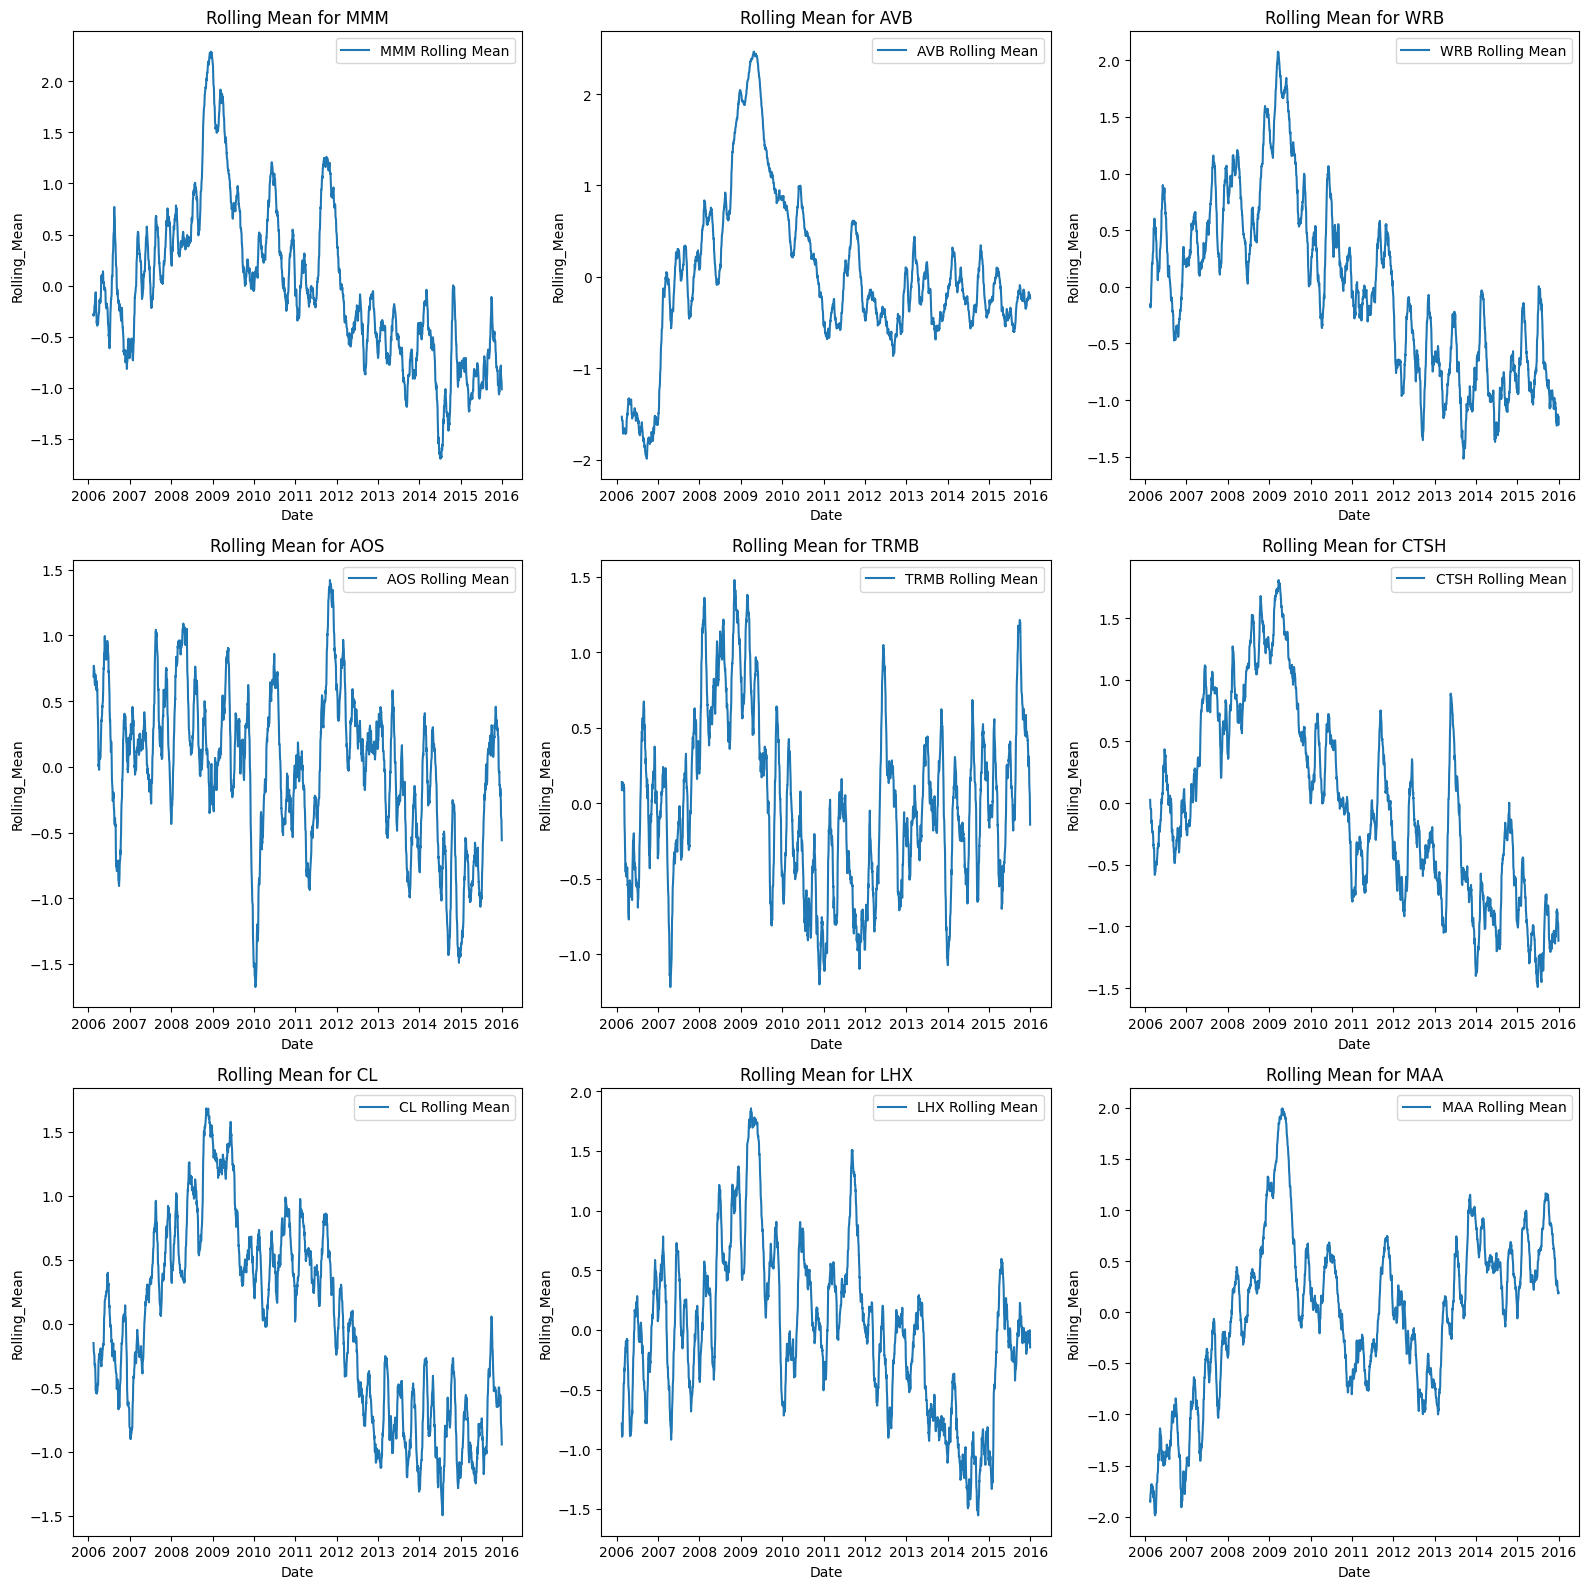

In [22]:
#Visualize the smoothed Volume

import seaborn as sns
import matplotlib.pyplot as plt

# Define the window size for the rolling mean
window_size = 30  # You can adjust the window size as needed (e.g., 30 days)

# Create a grid of subplots (3x4 for 12 tickers)
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through the first 12 tickers and create scatter plots with rolling mean
i = 0
for ticker in train.Ticker.unique()[:9]:
    # Filter data for the current ticker
    ticker_data = train.loc[train.Ticker == ticker]
    
    # Calculate the rolling mean for Dollar_Volume
    ticker_data['Rolling_Mean'] = ticker_data['Volume'].rolling(window=window_size).mean()
    
    # Plot the rolling mean
    sns.lineplot(x="Date", y="Rolling_Mean", data=ticker_data, ax=axes[i], label=f'{ticker} Rolling Mean')
    axes[i].set_title(f'Rolling Mean for {ticker}')  # Add title for each subplot
    axes[i].legend()

    i += 1

plt.tight_layout()  # To avoid overlap between subplots
plt.show()


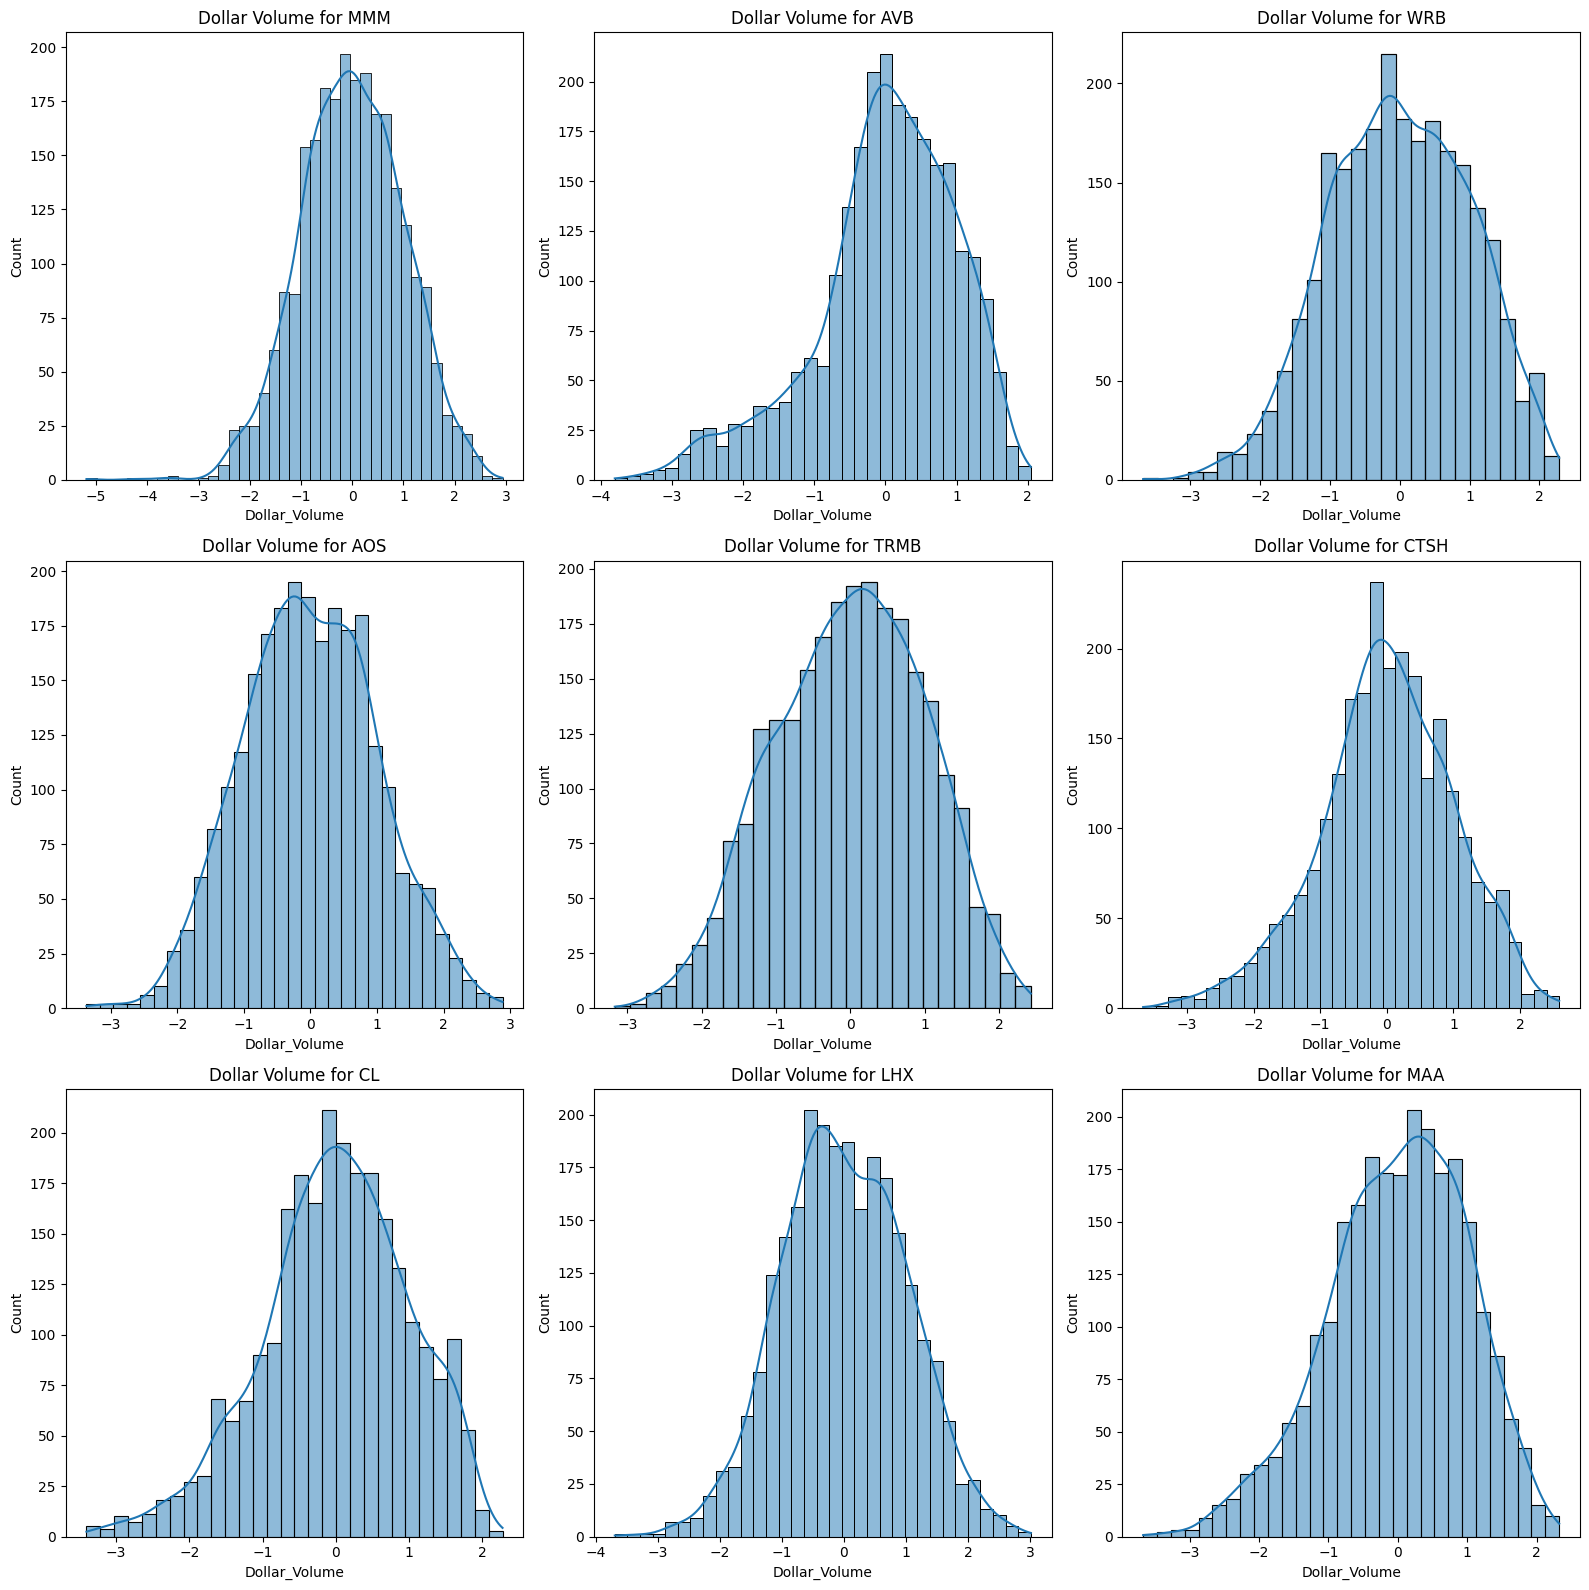

In [23]:
#Visualize the distribution of daily dollar volume
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through the first 12 tickers and create scatter plots
i = 0
for ticker in train.Ticker.unique()[:9]:
    sns.histplot(x="Dollar_Volume", data=train.loc[train.Ticker == ticker], ax=axes[i], kde = True)
    axes[i].set_title(f'Dollar Volume for {ticker}')  # Add title for each subplot
    i += 1

plt.tight_layout()  # To avoid overlap between subplots
plt.show()

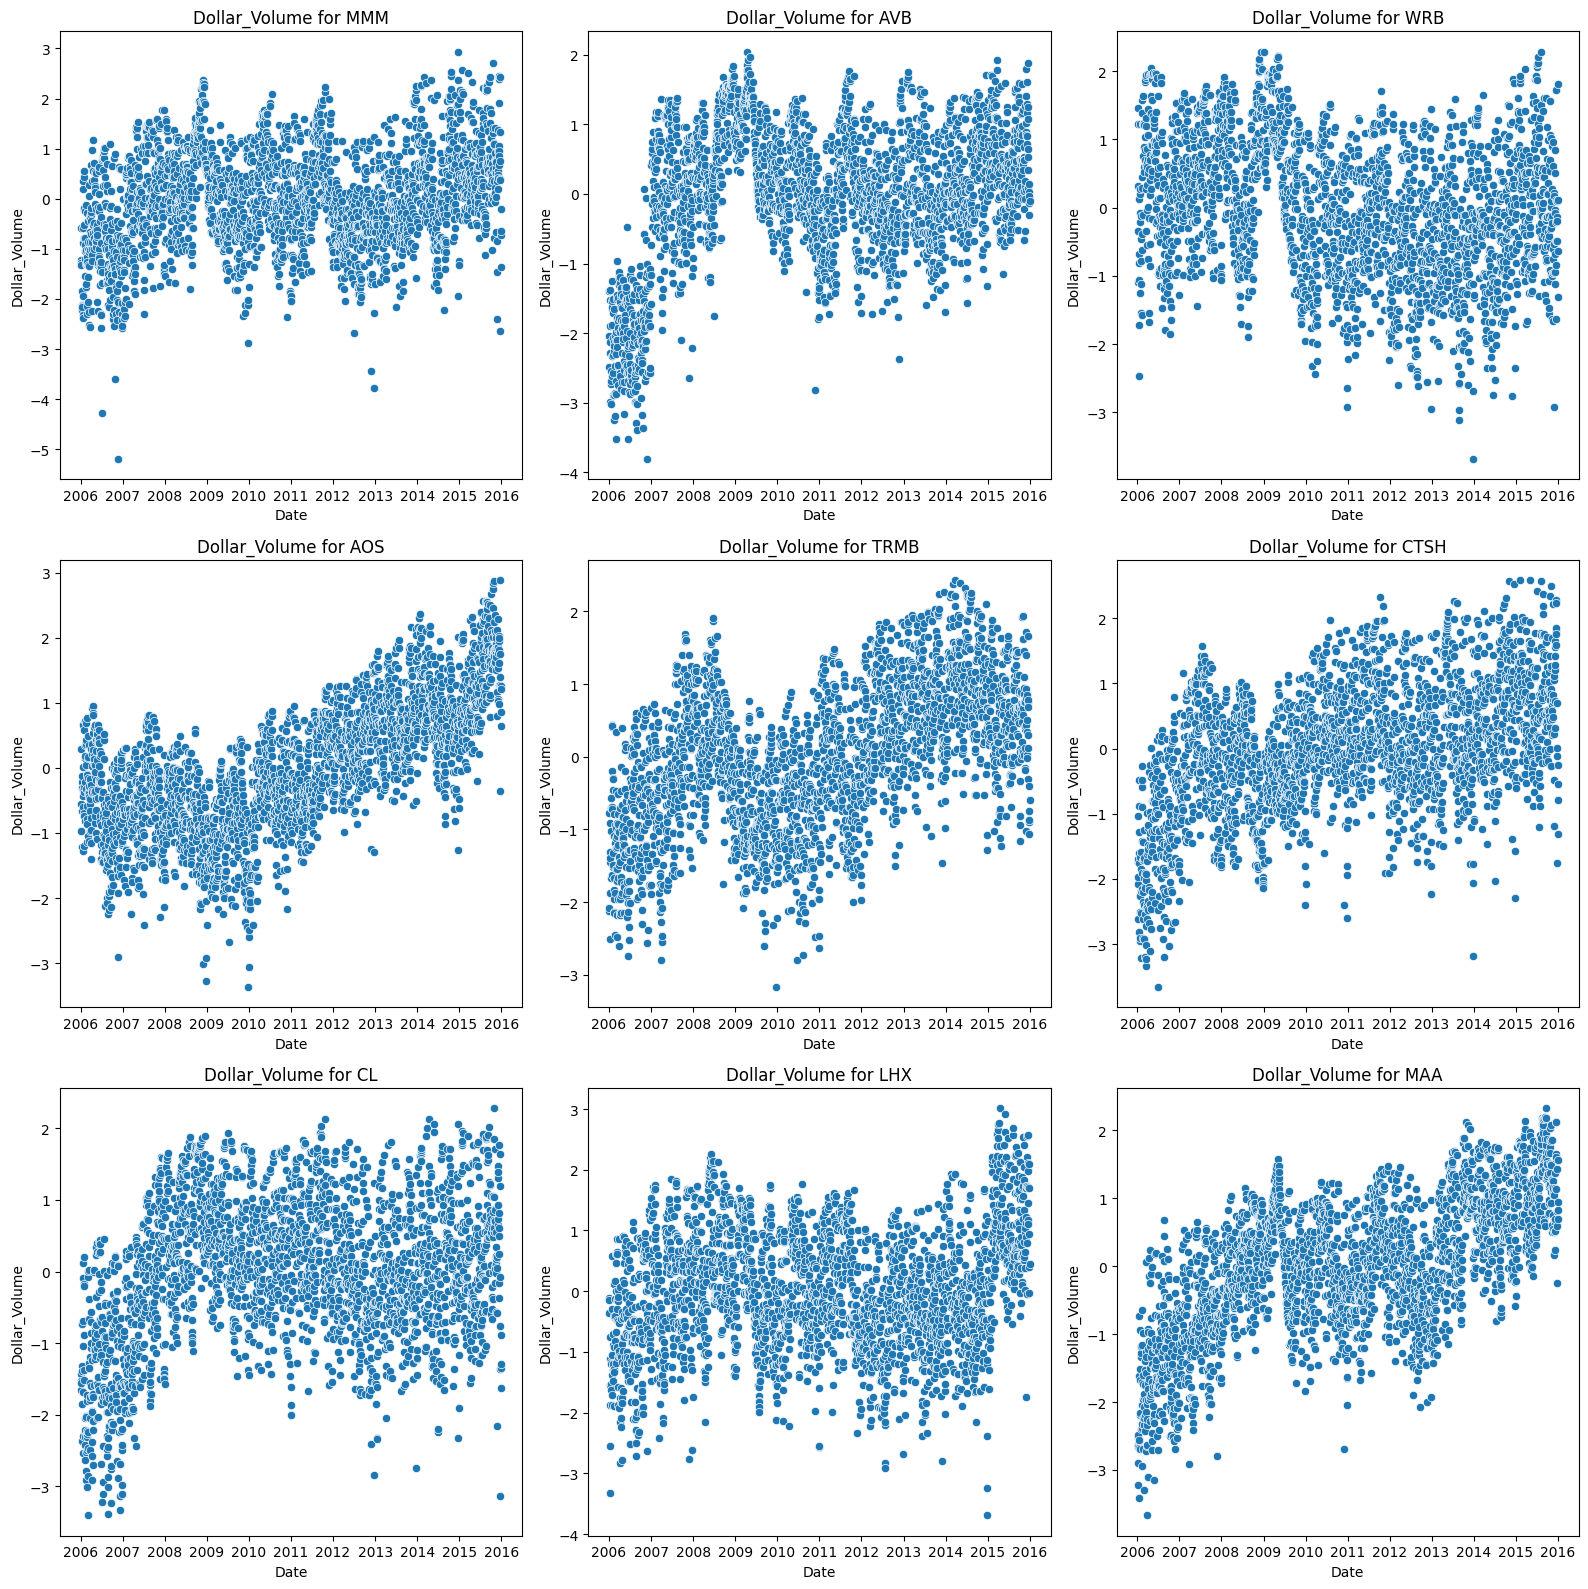

In [24]:
#Visualize the dollar Volume time series
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through the first 12 tickers and create scatter plots
i = 0
for ticker in train.Ticker.unique()[:9]:
    sns.scatterplot(x="Date", y="Dollar_Volume", data=train.loc[train.Ticker == ticker], ax=axes[i])
    axes[i].set_title(f'Dollar_Volume for {ticker}')  # Add title for each subplot
    i += 1

plt.tight_layout()  # To avoid overlap between subplots
plt.show()

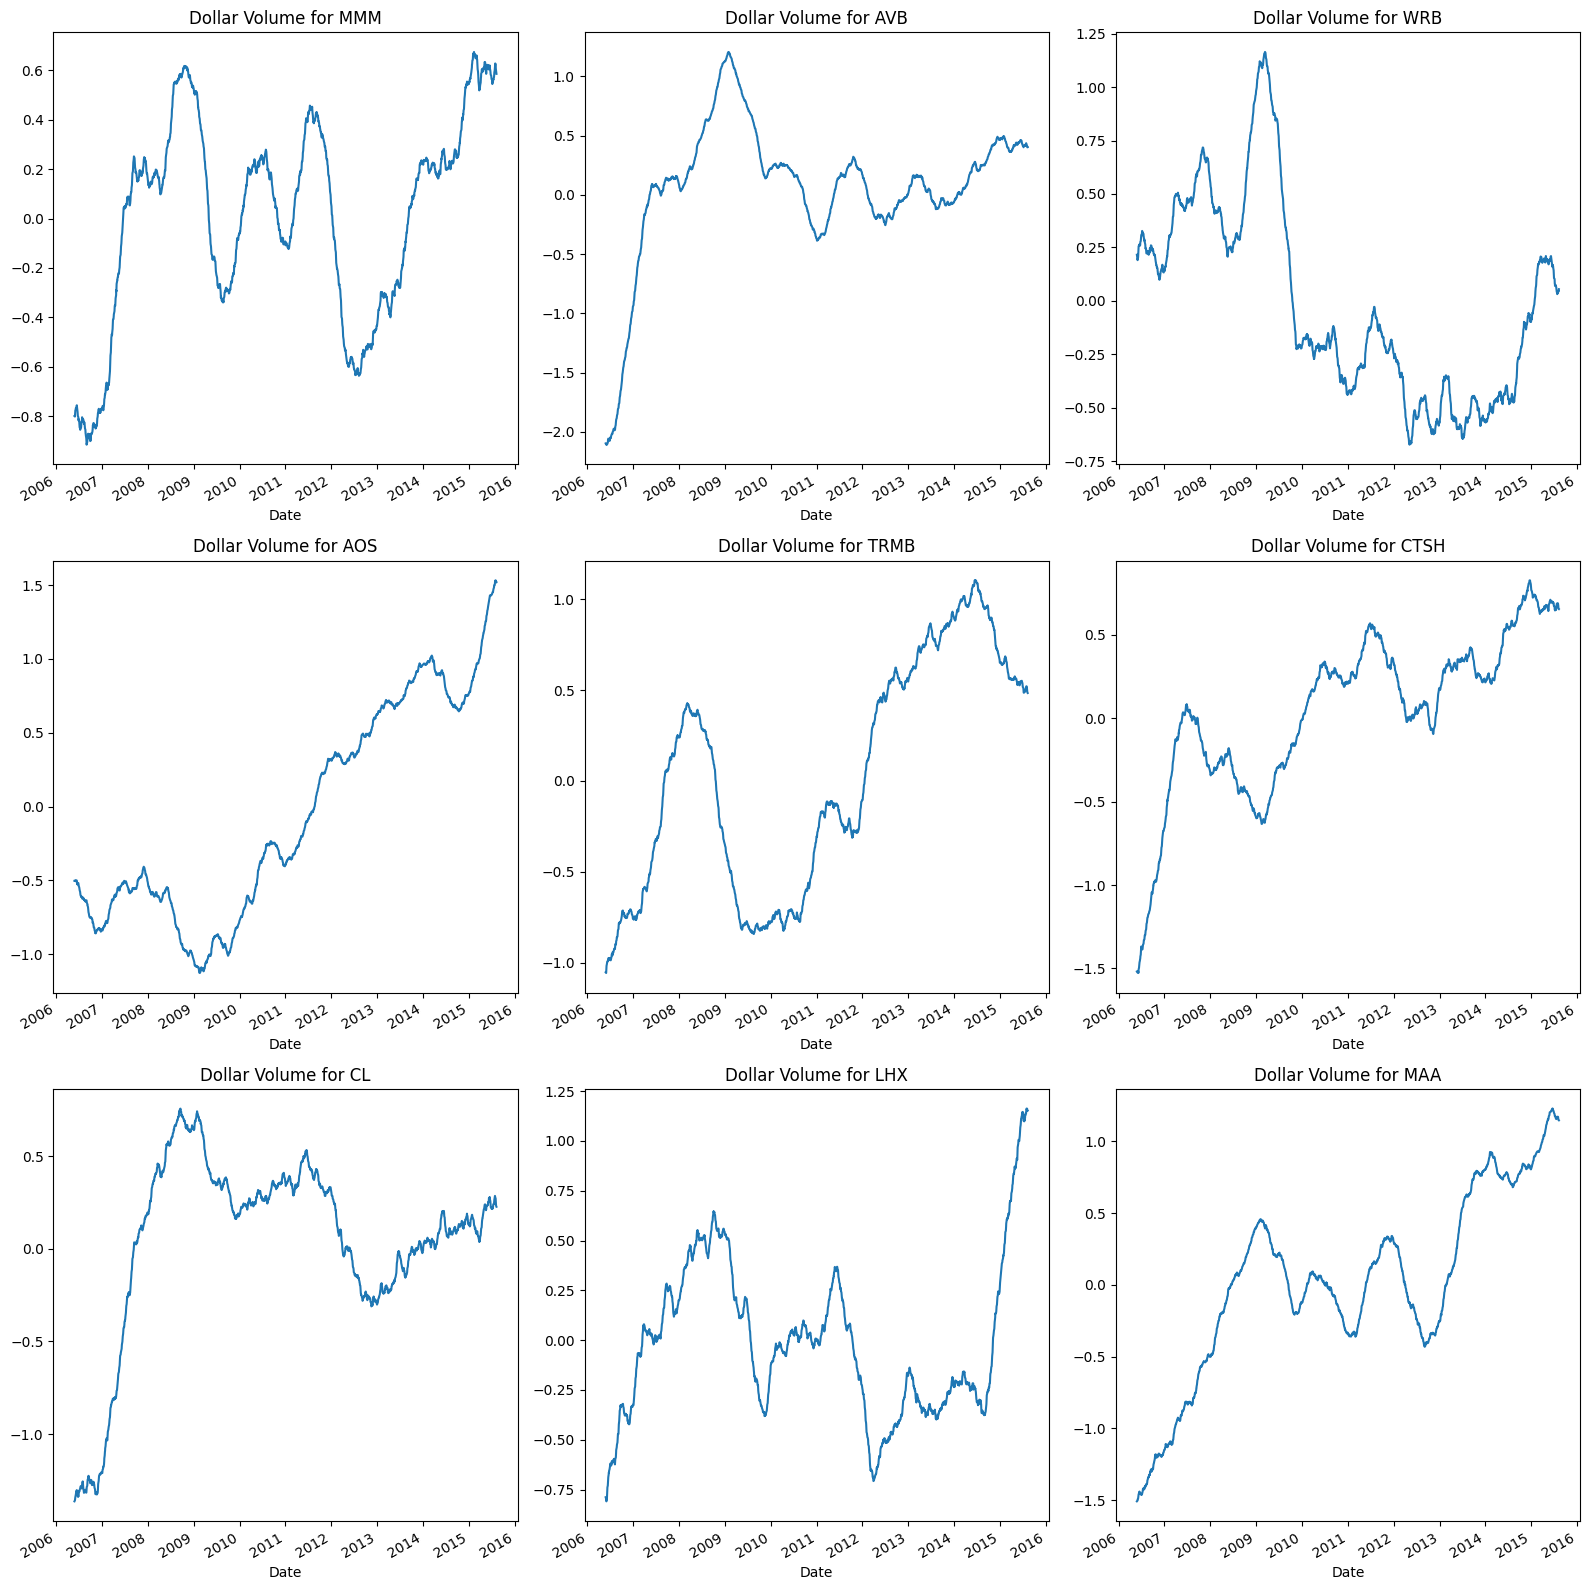

In [25]:
#Visualize the trend component of dollar Volume time series
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through the first 12 tickers and create scatter plots
i = 0
for ticker in train.Ticker.unique()[:9]:
    ticker_data = train.loc[train.Ticker == ticker]["Dollar_Volume"]
    #201 = 1005(number of days)/5(number of working days per week)
    decomposition = seasonal_decompose(ticker_data, model='additive', period=201)
    decomposition.trend.plot(ax=axes[i])
    axes[i].set_title(f'Dollar Volume for {ticker}')  # Add title for each subplot
    i += 1

plt.tight_layout()  # To avoid overlap between subplots
plt.show()

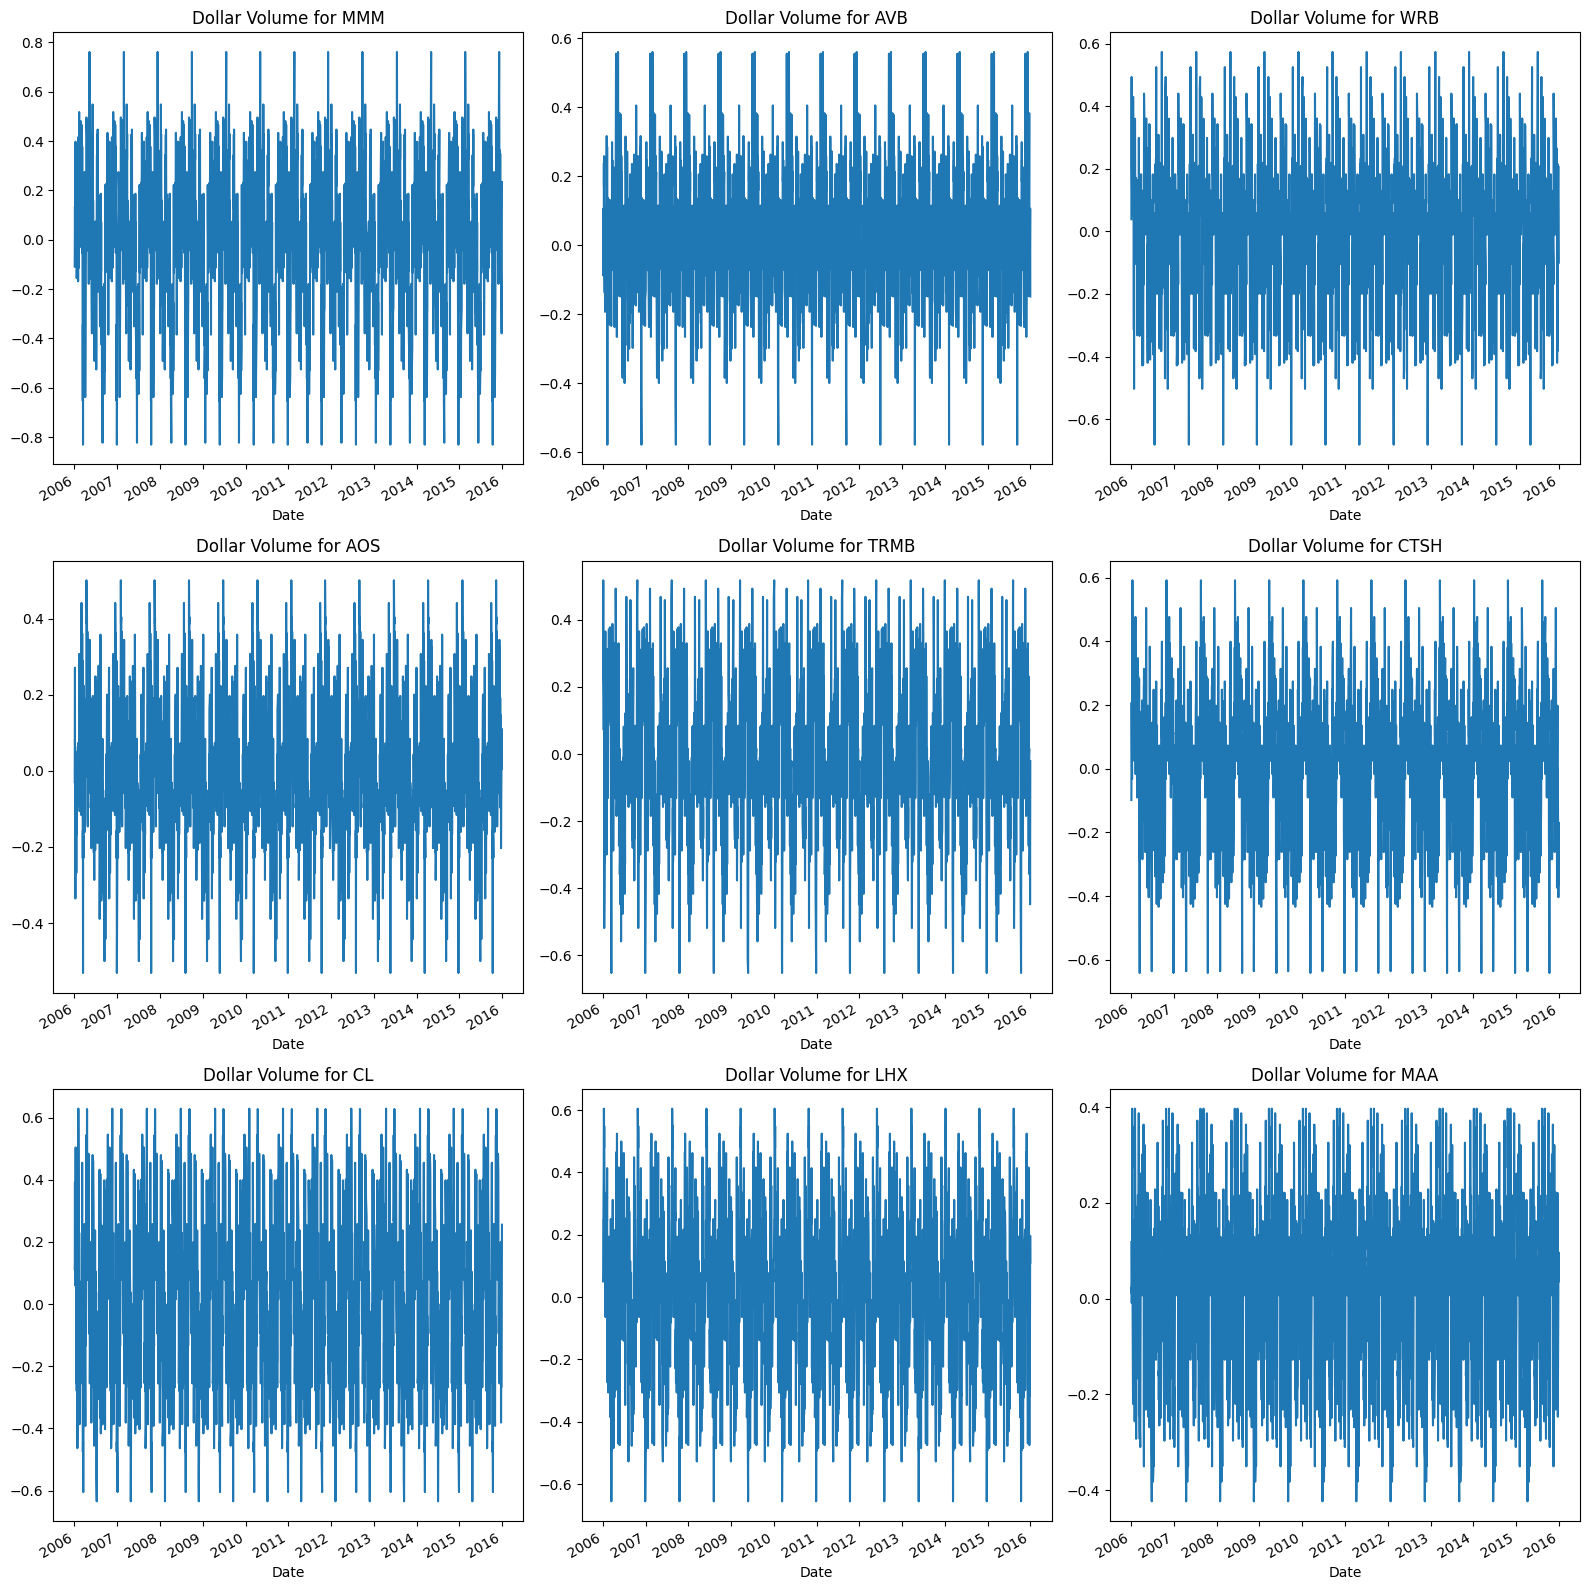

In [26]:
#Visualize the seasonal component of dollar Volume time series
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through the first 12 tickers and create scatter plots
i = 0
for ticker in train.Ticker.unique()[:9]:
    ticker_data = train.loc[train.Ticker == ticker]["Dollar_Volume"]
    #201 = 1005(number of days)/5(number of working days per week)
    decomposition = seasonal_decompose(ticker_data, model='additive', period=201)
    decomposition.seasonal.plot(ax=axes[i])
    axes[i].set_title(f'Dollar Volume for {ticker}')  # Add title for each subplot
    i += 1

plt.tight_layout()  # To avoid overlap between subplots
plt.show()

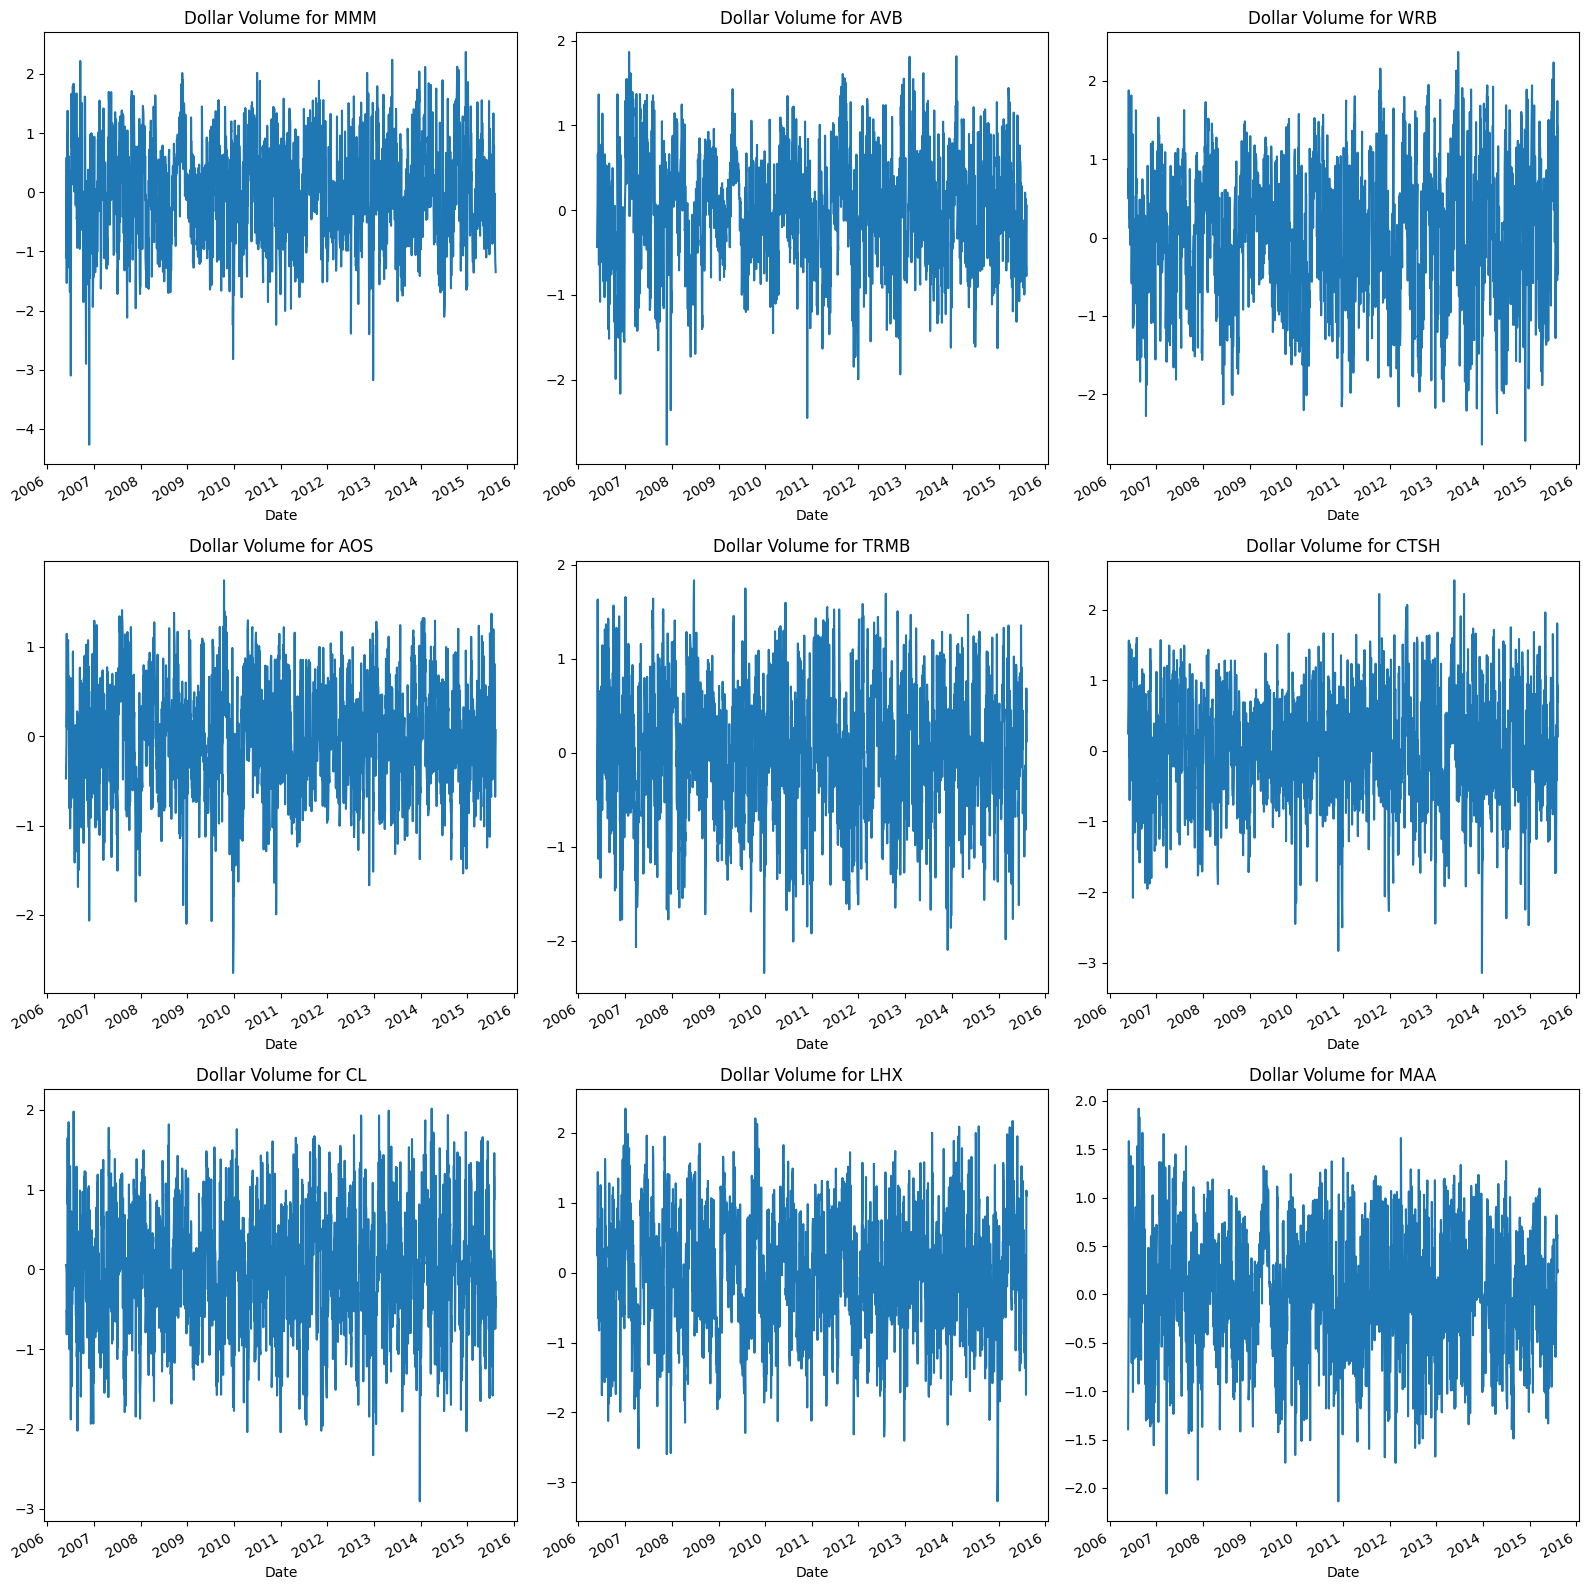

In [27]:
#Visualize the residual component of dollar Volume time series
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through the first 12 tickers and create scatter plots
i = 0
for ticker in train.Ticker.unique()[:9]:
    ticker_data = train.loc[train.Ticker == ticker]["Dollar_Volume"]
    #201 = 1005(number of days)/5(number of working days per week)
    decomposition = seasonal_decompose(ticker_data, model='additive', period=201)
    decomposition.resid.plot(ax=axes[i])
    axes[i].set_title(f'Dollar Volume for {ticker}')  # Add title for each subplot
    i += 1

plt.tight_layout()  # To avoid overlap between subplots
plt.show()

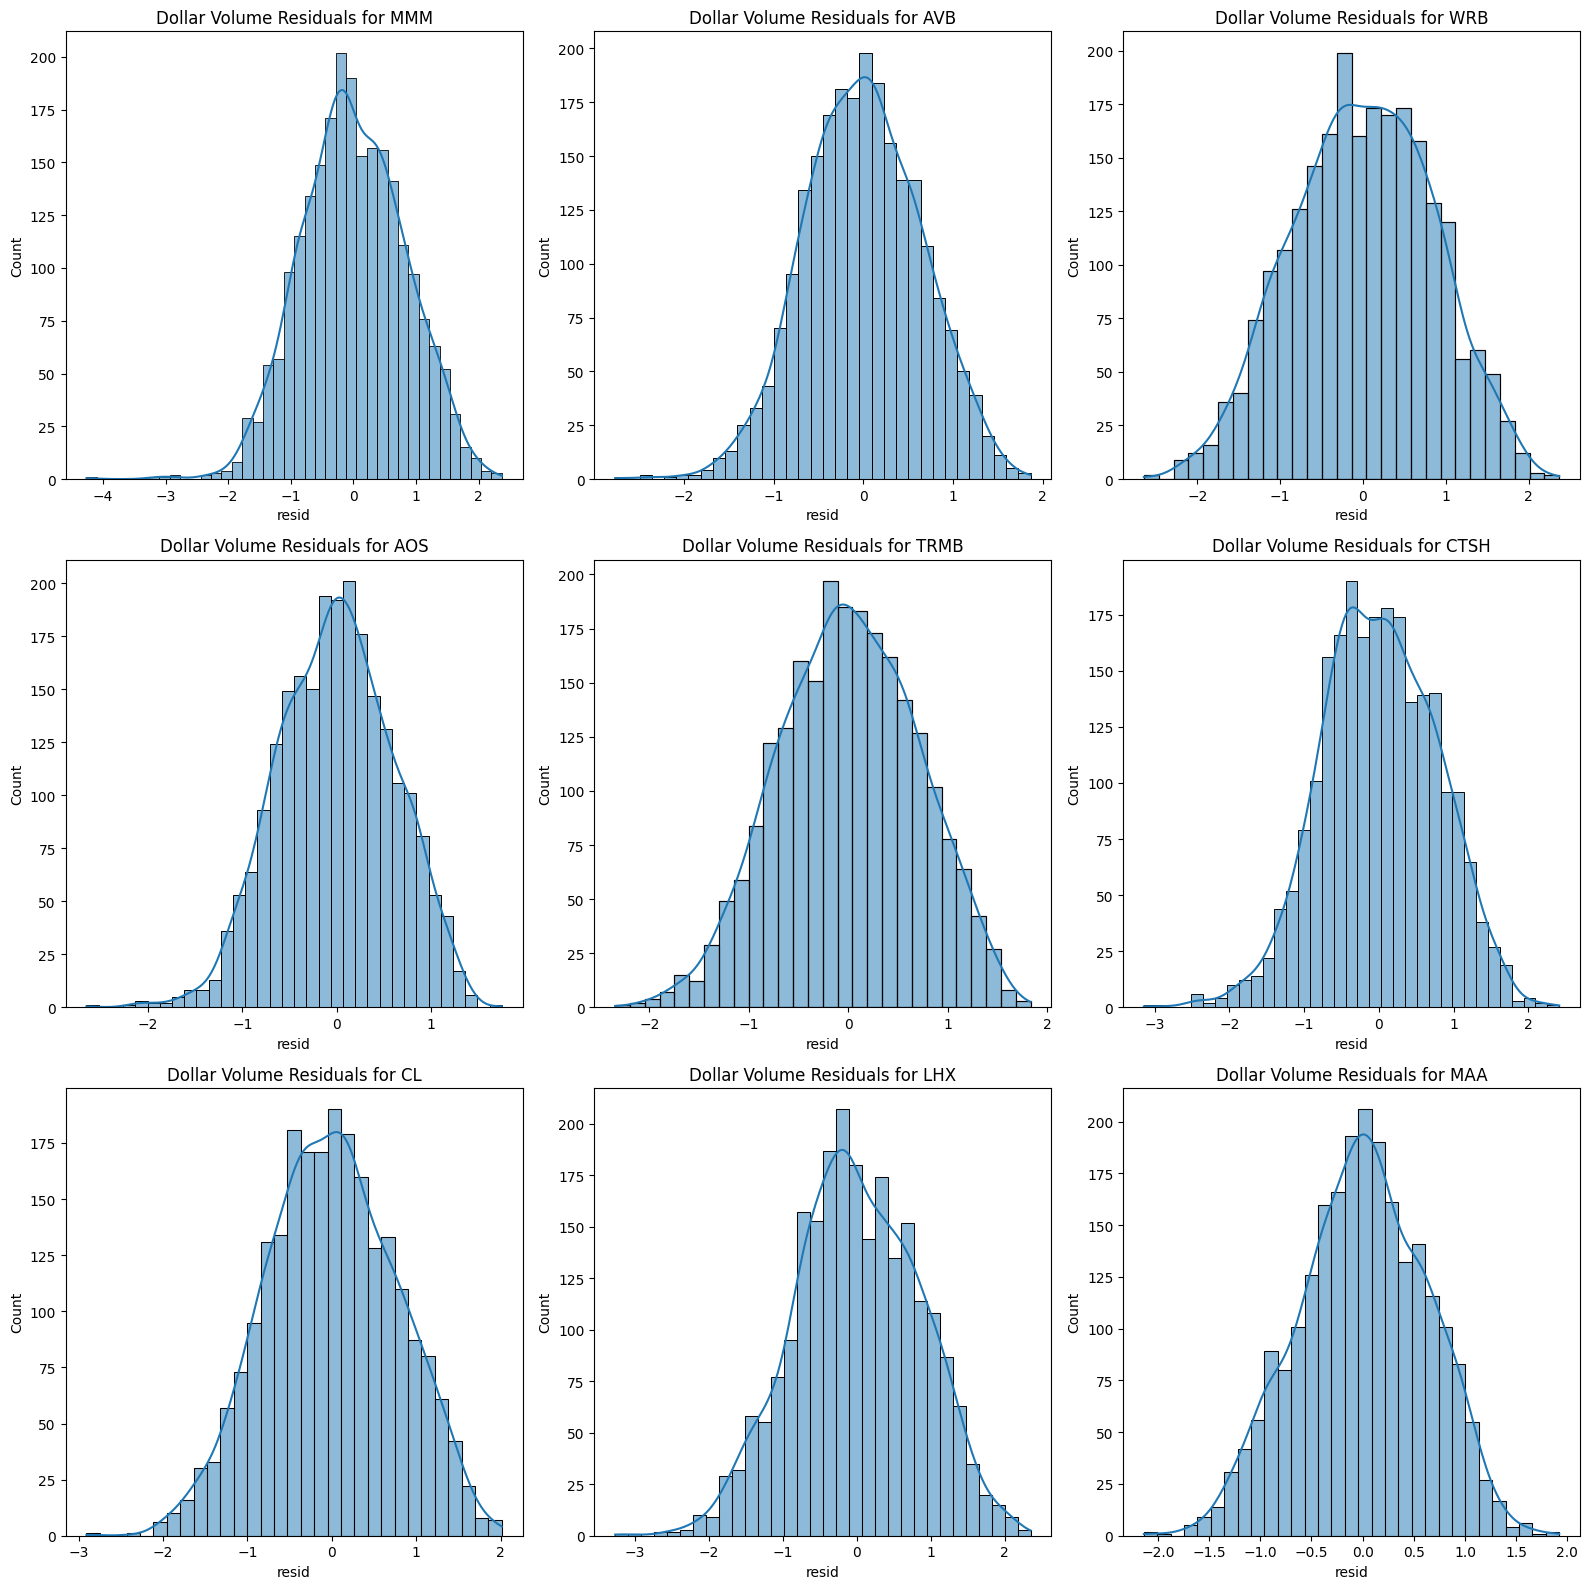

In [28]:
#Check the distribution of the residuals of dollar Volume time series, see if it is roughly normal
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Create subplots (3 rows and 3 columns)
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through the first 9 tickers and create scatter plots
i = 0
for ticker in train.Ticker.unique()[:9]:
    ticker_data = train.loc[train.Ticker == ticker]["Dollar_Volume"]
    
    # Decompose the time series (additive model) with a period of 201 (approx. one year of trading days)
    decomposition = seasonal_decompose(ticker_data, model='additive', period=201)
    
    # Plot the histogram of residuals with KDE
    sns.histplot(decomposition.resid.dropna(), kde=True, ax=axes[i])
    
    # Add title for each subplot
    axes[i].set_title(f'Dollar Volume Residuals for {ticker}')
    i += 1

# Adjust the layout for better spacing between subplots
plt.tight_layout()
plt.show()


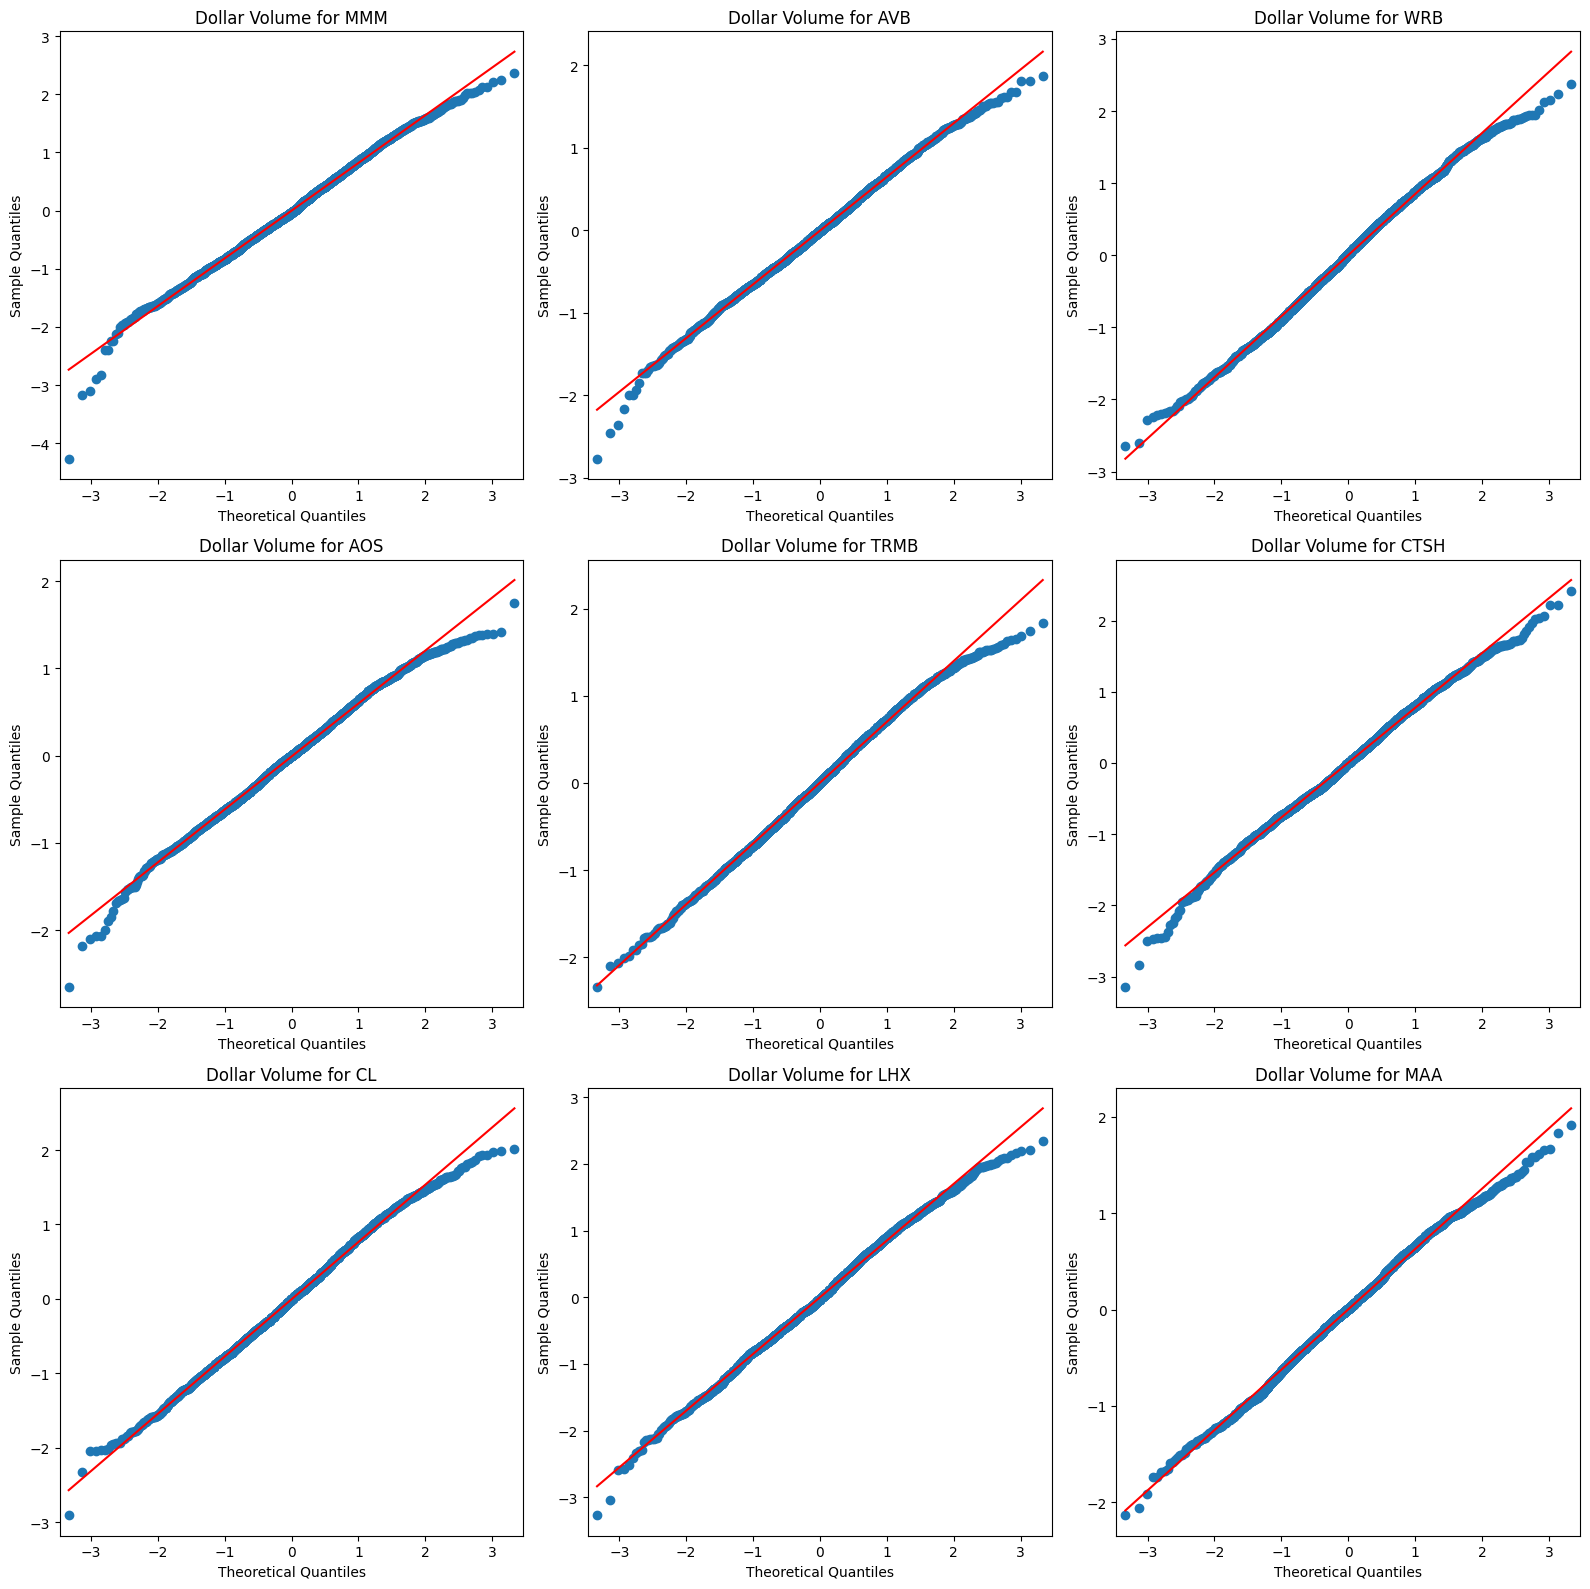

In [29]:
#Check the QQ plot of the residuals of dollar Volume time series, see if it is roughly normal
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through the first 12 tickers and create scatter plots
i = 0
for ticker in train.Ticker.unique()[:9]:
    ticker_data = train.loc[train.Ticker == ticker]["Dollar_Volume"]
    #201 = 1005(number of days)/5(number of working days per week)
    decomposition = seasonal_decompose(ticker_data, model='additive', period=201)
    sm.qqplot(decomposition.resid.dropna(), line="r", ax=axes[i])
    axes[i].set_title(f'Dollar Volume for {ticker}')  # Add title for each subplot
    i += 1

plt.tight_layout()  # To avoid overlap between subplots
plt.show()

### Step3: Selection of Evaluation Metrics

In [30]:
'''
1. Mean Absolute Error:

    MAE is easy to understand and interpret. It treats all errors equally, and hence is more robust to outliers. Given the noise and variance of the daily dollar volume, we believe MAE is the most important metric to look at.  Since we have scaled the Dollar\_Volume within each Ticker, it is safe to stack the error of different stocks all together and compute the MAE (otherwise we have to worry about the weights).\\

2. Root Mean Squared Error:

    RMSE is more sensitive to outliers compared to MAE. We use RMSE indeed of MSE because it is in the same scale as the original data.\\
     
3. Mean Absolute Percentage Error (MAPE):

    Although this metric is scale-independent, we realized it is {\it not} very useful here, because we found that, there are certain dates and certain stocks for which the volume is zero, then the percentage change will be huge. \\

4. R-square and Adjusted R-square: 

    Adjusted R-square accounts for the fact that adding more variables to the model always increases R-square, regardless of whether the new variables are truly relevant. \\

5. Trimmed MAE: 

    As shown in Figure \ref{fig:baseline}, there are unavoidable outliers in the testing data, leading to huge residuals. To address this, we trim the upper and lower 0.1\% of the residuals, before computing the MAE.\\

6. Trimmed Residual Variance:

    We compute the variance of the residual after trimming the extreme values. Since the QQ plot of the residual in the end is approximately normal, we believe the residual variance provides insight of the  quality of the prediction.  \\
    
7. Residuals Analysis:

    Residual analysis helps in detecting model mis-specification and patterns that the model hasn't captured. We use the QQ plot of the trimmed residual to investigate the behavior of the residuals.\\

8. Directional Accuracy:

    This metric computes the proportion of predictions that correctly forecasts whether the Dollar\_Volume the next day is increasing or decreasing. Due to the time constraints, we only implement this metric for the baseline model.\\

'''

"\n1. Mean Absolute Error:\n\n    MAE is easy to understand and interpret. It treats all errors equally, and hence is more robust to outliers. Given the noise and variance of the daily dollar volume, we believe MAE is the most important metric to look at.  Since we have scaled the Dollar\\_Volume within each Ticker, it is safe to stack the error of different stocks all together and compute the MAE (otherwise we have to worry about the weights).\\\n\n2. Root Mean Squared Error:\n\n    RMSE is more sensitive to outliers compared to MAE. We use RMSE indeed of MSE because it is in the same scale as the original data.\\\n     \n3. Mean Absolute Percentage Error (MAPE):\n\n    Although this metric is scale-independent, we realized it is {\\it not} very useful here, because we found that, there are certain dates and certain stocks for which the volume is zero, then the percentage change will be huge. \\\n\n4. R-square and Adjusted R-square: \n\n    Adjusted R-square accounts for the fact that

### Step4: Feature Engineering

In [31]:
# # Pivot the dataset to have stocks as columns and Dollar Volume as values
# pivoted_data = train.reset_index().pivot(index="Date", columns="Ticker", values="Dollar_Volume")

# # Compute the correlation matrix for Dollar Volume among different stocks
# random_tickers = random.sample(tickers, 15)
# correlation_matrix = pivoted_data[random_tickers].corr()

# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
# plt.title("Correlation of Dollar Volume Among Stocks")
# plt.show()

In [32]:
for df in [train, test]:
    df["Sector"] = df.Ticker.map(ticker_sector_dict)

In [33]:
train

Open      High       Low     Close  Adj Close    Volume  \
Date                                                                      
2006-01-03 -0.603797 -0.567181 -0.593403 -0.545658  -0.813890 -0.066922   
2006-01-03 -0.813818 -0.816326 -0.791531 -0.764467  -1.140294 -0.779574   
2006-01-03 -0.226477 -0.254085 -0.233211 -0.234667  -0.386204  1.272728   
2006-01-03 -1.009530 -0.965998 -0.985045 -0.942106  -1.006580  0.478425   
2006-01-03 -1.763322 -1.771282 -1.732340 -1.735594  -1.735594  0.599302   
...              ...       ...       ...       ...        ...       ...   
2015-12-31  2.333416  2.321737  2.311091  2.298050   2.298157 -1.639618   
2015-12-31  1.986078  1.972039  1.962787  1.930014   2.029838 -2.623262   
2015-12-31  1.523373  1.531205  1.517760  1.522849   1.524364 -1.806152   
2015-12-31  2.113085  2.119122  2.076389  2.093372   2.061705 -1.293033   
2015-12-31 -0.004592  0.007328 -0.036360 -0.021346   0.133282  0.096070   

           Ticker  Dollar_Volume                  Sector  
Date                                                      
2006-01-03    MMM      -0.582110             Industrials  
2006-01-03    AVB      -1.401741             Real Estate  
2006-01-03    WRB       1.459622              Financials  
2006-01-03    AOS      -0.558200             Industrials  
2006-01-03   TRMB      -0.775812  Information Technology  
...           ...            ...                     ...  
2015-12-31   GOOG      -0.733144  Communication Services  
2015-12-31   INTC      -2.130585  Information Technology  
2015-12-31   CTSH      -0.249678  Information Technology  
2015-12-31    CAG      -0.109148        Consumer Staples  
2015-12-31    EQT       0.063229                  Energy  

[1104861 rows x 9 columns]

In [34]:
def calculate_cumsum(data):
    
    data = data.copy()
    
    data["Close_CUM"] = data.groupby('Ticker')["Close"].transform(lambda x: x.cumsum())
    data["Dollar_Volume_CUM"] = data.groupby('Ticker')["Dollar_Volume"].transform(lambda x: x.cumsum())
    
    return data, ["Close_CUM", "Dollar_Volume_CUM"]

In [35]:
def calculate_sma(data, window=20):

    data = data.copy()

    # Calculate SMA of daily returns
    data["Volume_SMA"] = data.groupby('Ticker')["Volume"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    data["Close_SMA"] = data.groupby('Ticker')["Close"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    data["Dollar_Volume_SMA"] = data.groupby('Ticker')["Dollar_Volume"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    
    # Calculate SMA of cumulative returns
    data["Close_CUM_SMA"] = data.groupby('Ticker')["Close_CUM"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    data["Dollar_Volume_CUM_SMA"] = data.groupby('Ticker')["Dollar_Volume_CUM"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())

    return data, ["Volume_SMA", "Close_SMA", "Dollar_Volume_SMA", "Close_CUM_SMA", "Dollar_Volume_CUM_SMA"]

In [36]:
def calculate_ema(data, window=20):

    data = data.copy()

    # Calculate EMA of daily returns
    data["Volume_EMA"] = data.groupby('Ticker')["Volume"].transform(lambda x: x.ewm(span=window, adjust=False).mean())
    data["Close_EMA"] = data.groupby('Ticker')["Close"].transform(lambda x: x.ewm(span=window, adjust=False).mean())
    data["Dollar_Volume_EMA"] = data.groupby('Ticker')["Dollar_Volume"].transform(lambda x: x.ewm(span=window, adjust=False).mean())
    
    # Calculate EMA of cumulative returns
    data["Close_CUM_EMA"] = data.groupby('Ticker')["Close_CUM"].transform(lambda x: x.ewm(span=window, adjust=False).mean())
    data["Dollar_Volume_CUM_EMA"] = data.groupby('Ticker')["Dollar_Volume_CUM"].transform(lambda x: x.ewm(span=window, adjust=False).mean())

    return data, ["Volume_EMA", "Close_EMA", "Dollar_Volume_EMA", "Close_CUM_EMA", "Dollar_Volume_CUM_EMA"]

In [37]:
def calculate_datetime(data):
    
    data = data.copy()
    
    data["Year"] = data.index.year
    data["Month"] = data.index.month
    data["Dayofmonth"] = data.index.day
    data["Dayofweek"] = data.index.dayofweek
    data["Quarter"] = data.index.quarter
    
    return data, ["Year", "Month", "Dayofmonth", "Dayofweek", "Quarter"]

In [38]:
def calculate_roc(data):
    """
    Calculate the percentage change for Close, Volume, and Dollar_Volume for each stock,
    and handle NaN values by filling with 0.
    """
    data = data.copy()
    feature_names = []

    # Calculate percentage change for Close, Volume, and Dollar_Volume
    for col in ['Close']:
        pct_change_col_name = f'{col}_ROC'
        data[pct_change_col_name] = data.groupby('Ticker')[col].pct_change()
        data[pct_change_col_name].fillna(0, inplace=True)  # Fill NaN with 0
        feature_names.append(pct_change_col_name)
        
    return data, feature_names

In [39]:
def calculate_rsi(data, window=14):
    """
    Calculate the RSI for each ticker in the dataset.

    Parameters:
        data (pd.DataFrame): DataFrame containing stock price data.
        window (int): Lookback period for RSI calculation (default is 14).

    Returns:
        tuple: Updated DataFrame with RSI and a list of newly added column names.
    """
    data = data.copy()
    
    # Compute the RSI within each group (by Ticker)
    data["RSI"] = data.groupby('Ticker')["Close"].transform(
        lambda x: compute_rsi(x, window=window)
    )
    data['RSI_overbought'] = np.where(data['RSI'] > 70, 1, 0)
    data['RSI_oversold'] = np.where(data['RSI'] < 30, 1, 0)
    
    return data, ["RSI", "RSI_overbought", "RSI_oversold"]

def compute_rsi(data, window=14):
    """
    Helper function to compute RSI for a single series of prices.

    Parameters:
        data (pd.Series): Series of stock prices.
        window (int): Lookback period for RSI calculation.

    Returns:
        pd.Series: RSI values.
    """
    # Calculate price changes
    delta = data.diff()

    # Separate gains and losses
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    # Calculate the average gain and loss
    avg_gain = pd.Series(gain, index=data.index).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss, index=data.index).rolling(window=window, min_periods=1).mean()

    # Calculate the relative strength (RS)
    rs = avg_gain / (avg_loss + 1e-10)  # Avoid division by zero

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

In [40]:
def calculate_momentum(data, window=10):
    """
    Calculate momentum for each stock based on the price minus the moving average over the last `window` days.

    Parameters:
        data (pd.DataFrame): DataFrame containing stock price data with "Ticker" and "Close" columns.
        window (int): Lookback period for moving average calculation (default is 10).

    Returns:
        tuple: Updated DataFrame with momentum and a list of newly added column names.
    """
    data = data.copy()

    # Calculate the moving average over the past `window` days
    close_moving_average = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())

    # Calculate momentum: current price minus the moving average of the past `window` days
    data["Close_Momentum"] = data['Close'] - close_moving_average
    
    volume_moving_average = data.groupby('Ticker')['Volume'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())

    # Calculate momentum: current price minus the moving average of the past `window` days
    data["Volume_Momentum"] = data['Volume'] - volume_moving_average
    
    dollar_volume_moving_average = data.groupby('Ticker')['Dollar_Volume'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())

    # Calculate momentum: current price minus the moving average of the past `window` days
    data["Dollar_Volume_Momentum"] = data['Dollar_Volume'] - dollar_volume_moving_average
    
    return data, ["Close_Momentum", "Volume_Momentum", "Dollar_Volume_Momentum"]

In [41]:
def calculate_sector_aggregated_features(data):
    """
    Calculate conditional aggregated features for the given shifts, statistics, and group-by features.

    Args:
    train: pd.DataFrame, training data containing target features and group-by features.
    test: pd.DataFrame, testing data containing target features and group-by features.
    shifts: list, list of shifts to calculate (default: [1, 2, 3, 4]).
    statistics: list, list of statistics to calculate (default: ['mean']).
    gb_features_list: list, list of group-by feature lists (default: [['SECTOR', 'DATE']]).
    target_features: list, list of target features to calculate (default: ['RET']).

    Returns:
    pd.DataFrame for train and test with added conditional aggregated features.
    list of new feature names.
    """
    
    data = data.copy()
    
    feature_names = []
    
    for col in ["Close", "Volume", "Dollar_Volume"]:
        for stat in ["mean", "std"]:

            name = f'{col}_{stat}_Sector'
            feature_names.append(name)
            data[name] = data.groupby(["Date", "Sector"])[col].transform(stat)
    
    return data, feature_names


def calculate_rolling_std(data, window=20):
    """
    Calculate rolling standard deviation for various columns, with special handling for window=1.
    
    Parameters:
        data (pd.DataFrame): The input data with columns 'Volume', 'Close', 'Dollar_Volume', 'Close_CUM', and 'Dollar_Volume_CUM'.
        window (int): The rolling window size (default is 20).

    Returns:
        pd.DataFrame: DataFrame with added rolling standard deviation columns.
        list: List of newly created column names.
    """
    data = data.copy()

    def rolling_std_fixed(x):
        rolling_std = x.rolling(window=window, min_periods=1).std()
        return rolling_std.fillna(0)  # Replace NaN with 0 for cases where the window=1.

    # Calculate rolling standard deviation
    data["Volume_STD"] = data.groupby('Ticker')["Volume"].transform(rolling_std_fixed)
    data["Close_STD"] = data.groupby('Ticker')["Close"].transform(rolling_std_fixed)
    data["Dollar_Volume_STD"] = data.groupby('Ticker')["Dollar_Volume"].transform(rolling_std_fixed)

    return data, ["Volume_STD", "Close_STD", "Dollar_Volume_STD"]


In [42]:
def encode_sector(train, test):
    
    train = train.copy()
    test = test.copy()
    
    onehot = OneHotEncoder(sparse=False)
    encoded_train = onehot.fit_transform(train.Sector.values.reshape(-1,1))
    
    encoded_train = pd.DataFrame(encoded_train, columns=onehot.categories_[0], index = train.index)
    
    train = pd.concat([train, encoded_train], axis=1)
    
    encoded_test = onehot.transform(test.Sector.values.reshape(-1,1))
    
    encoded_test = pd.DataFrame(encoded_test, columns=onehot.categories_[0], index = test.index)
    
    test = pd.concat([test, encoded_test], axis=1)
    
    return train, test, onehot.categories_[0].tolist()

In [43]:
def calculate_cci(data, window=20):
    """
    Calculate the Commodity Channel Index (CCI) for each Ticker.

    Parameters:
        data (pd.DataFrame): Input DataFrame containing columns "High", "Low", and "Close".
        window (int): Rolling window size for calculating CCI (default is 20).

    Returns:
        pd.DataFrame, list: Updated DataFrame with CCI column and a list of generated column names.
    """
    data = data.copy()

    # Calculate the Typical Price
    data["Typical_Price"] = (data["High"] + data["Low"] + data["Close"]) / 3

    # Calculate the SMA of the Typical Price
    data["Typical_Price_SMA"] = data.groupby('Ticker')["Typical_Price"].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )

    # Calculate the Mean Absolute Deviation (MAD) of the Typical Price
    data["Typical_Price_MAD"] = data.groupby('Ticker')["Typical_Price"].transform(
        lambda x: x.rolling(window=window, min_periods=1).apply(lambda y: np.mean(np.abs(y - np.mean(y))), raw=True)
    )

    # Calculate CCI
    data["CCI"] = ((data["Typical_Price"] - data["Typical_Price_SMA"]) / (0.015 * data["Typical_Price_MAD"])).fillna(0)

    return data, ["CCI"]

In [44]:
def calculate_wr(data, window=14):
    """
    Calculate the Williams %R (WR) for each Ticker.

    Parameters:
        data (pd.DataFrame): Input DataFrame containing columns "High", "Low", and "Close".
        window (int): Rolling window size for calculating WR (default is 14).

    Returns:
        pd.DataFrame, list: Updated DataFrame with WR column and a list of generated column names.
    """
    data = data.copy()

    # Calculate the rolling highest high and lowest low
    data["High_Max"] = data.groupby('Ticker')["High"].transform(
        lambda x: x.rolling(window=window, min_periods=1).max()
    )
    data["Low_Min"] = data.groupby('Ticker')["Low"].transform(
        lambda x: x.rolling(window=window, min_periods=1).min()
    )

    # Calculate Williams %R
    data["WR"] = -100 * (data["High_Max"] - data["Close"]) / (data["High_Max"] - data["Low_Min"])

    return data, ["WR"]

In [45]:
def calculate_atr(data, window=14):
    """
    Calculate the Average True Range (ATR) for each Ticker.

    Parameters:
        data (pd.DataFrame): Input DataFrame containing columns "High", "Low", and "Close".
        window (int): Rolling window size for calculating ATR (default is 14).

    Returns:
        pd.DataFrame, list: Updated DataFrame with ATR column and a list of generated column names.
    """
    data = data.copy()

    # Calculate True Range (TR)
    data["TR"] = data.groupby('Ticker').apply(
        lambda x: np.maximum.reduce([
            x["High"] - x["Low"],
            abs(x["High"] - x["Close"].shift(1)),
            abs(x["Low"] - x["Close"].shift(1))
        ])
    ).reset_index(level=0, drop=True)

    # Calculate ATR using a rolling mean of True Range
    data["ATR"] = data.groupby('Ticker')["TR"].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )

    return data, ["ATR"]


In [46]:
def calculate_kdj(data, window=14):
    """
    Calculate the KDJ indicator for each Ticker.

    Parameters:
        data (pd.DataFrame): Input DataFrame containing columns "High", "Low", and "Close".
        window (int): Rolling window size for calculating KDJ (default is 14).

    Returns:
        pd.DataFrame, list: Updated DataFrame with KDJ columns (%K, %D, %J) and a list of generated column names.
    """
    data = data.copy()

    # Calculate the rolling highest high and lowest low
    data["High_Max"] = data.groupby('Ticker')["High"].transform(
        lambda x: x.rolling(window=window, min_periods=1).max()
    )
    data["Low_Min"] = data.groupby('Ticker')["Low"].transform(
        lambda x: x.rolling(window=window, min_periods=1).min()
    )

    # Calculate %K
    data["%K"] = 100 * (data["Close"] - data["Low_Min"]) / (data["High_Max"] - data["Low_Min"])

    # Calculate %D (simple moving average of %K)
    data["%D"] = data.groupby('Ticker')["%K"].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean()
    )

    # Calculate %J
    data["%J"] = 3 * data["%K"] - 2 * data["%D"]

    return data, ["%K", "%D", "%J"]

In [47]:
def calculate_cmf(data, window=20):
    """
    Calculate the Chaikin Money Flow (CMF) for each Ticker.

    Parameters:
        data (pd.DataFrame): Input DataFrame containing columns "High", "Low", "Close", and "Volume".
        window (int): Rolling window size for calculating CMF (default is 20).

    Returns:
        pd.DataFrame, list: Updated DataFrame with CMF column and a list of generated column names.
    """
    data = data.copy()

    # Calculate Money Flow Multiplier
    data["Money_Flow_Multiplier"] = ((data["Close"] - data["Low"]) - (data["High"] - data["Close"])) / (data["High"] - data["Low"])
    data["Money_Flow_Multiplier"] = data["Money_Flow_Multiplier"].fillna(0)  # Handle division by zero

    # Calculate Money Flow Volume
    data["Money_Flow_Volume"] = data["Money_Flow_Multiplier"] * data["Volume"]

    # Calculate CMF as the sum of Money Flow Volume over the rolling window divided by the sum of Volume
    data["CMF"] = data.groupby('Ticker').apply(
        lambda x: x["Money_Flow_Volume"].rolling(window=window, min_periods=1).sum() /
                  x["Volume"].rolling(window=window, min_periods=1).sum()
    ).reset_index(level=0, drop=True)

    return data, ["CMF"]


In [48]:
def calculate_macdh(data, fast_window=12, slow_window=26, signal_window=9):
    """
    Calculate the MACD line, Signal line, and MACD Histogram (MACDH) for each Ticker.

    Parameters:
        data (pd.DataFrame): Input DataFrame containing a "Close" column.
        fast_window (int): Window size for the fast EMA (default is 12).
        slow_window (int): Window size for the slow EMA (default is 26).
        signal_window (int): Window size for the signal line EMA (default is 9).

    Returns:
        pd.DataFrame, list: Updated DataFrame with MACD-related columns and a list of generated column names.
    """
    data = data.copy()

    # Calculate the fast and slow EMAs
    data["EMA_Fast"] = data.groupby('Ticker')["Close"].transform(
        lambda x: x.ewm(span=fast_window, adjust=False).mean()
    )
    data["EMA_Slow"] = data.groupby('Ticker')["Close"].transform(
        lambda x: x.ewm(span=slow_window, adjust=False).mean()
    )

    # Calculate the MACD line
    data["MACD_Line"] = data["EMA_Fast"] - data["EMA_Slow"]

    # Calculate the Signal line
    data["Signal_Line"] = data.groupby('Ticker')["MACD_Line"].transform(
        lambda x: x.ewm(span=signal_window, adjust=False).mean()
    )

    # Calculate the MACD Histogram (MACDH)
    data["MACDH"] = data["MACD_Line"] - data["Signal_Line"]

    return data, ["MACD_Line", "MACDH"]

In [49]:
new_features = []

train, feature_names = calculate_cumsum(train)
test, _ = calculate_cumsum(test)
new_features.extend(feature_names)

train, feature_names = calculate_sma(train)
test, _ = calculate_sma(test)
new_features.extend(feature_names)

train, feature_names = calculate_ema(train)
test, _ = calculate_ema(test)
new_features.extend(feature_names)

train, feature_names = calculate_datetime(train)
test, _ = calculate_datetime(test)
new_features.extend(feature_names)

# train, feature_names = calculate_train_vwap(train)
# test, _ = calculate_test_vwap(test)
# new_features.extend(feature_names)

# train, feature_names = calculate_roc(train)
# test, _ = calculate_roc(test)
# new_features.extend(feature_names)

train, feature_names = calculate_rsi(train)
test, _ = calculate_rsi(test)
new_features.extend(feature_names)

train, feature_names = calculate_momentum(train)
test, _ = calculate_momentum(test)
new_features.extend(feature_names)

train, feature_names = calculate_sector_aggregated_features(train)
test, _ = calculate_sector_aggregated_features(test)
new_features.extend(feature_names)

# train, feature_names = calculate_rolling_std(train)
# test, _ = calculate_rolling_std(test)
# new_features.extend(feature_names)

train, feature_names = calculate_cci(train)
test, _ = calculate_cci(test)
new_features.extend(feature_names)

# train, feature_names = calculate_atr(train)
# test, _ = calculate_atr(test)
# new_features.extend(feature_names)

# train, feature_names = calculate_cmf(train)
# test, _ = calculate_cmf(test)
# new_features.extend(feature_names)

# train, feature_names = calculate_macdh(train)
# test, _ = calculate_macdh(test)
# new_features.extend(feature_names)

# train, feature_names = calculate_kdj(train)
# test, _ = calculate_kdj(test)
# new_features.extend(feature_names)

# train, feature_names = calculate_wr(train)
# test, _ = calculate_wr(test)
# new_features.extend(feature_names)

train, test, feature_names = encode_sector(train, test)
new_features.extend(feature_names)

In [50]:
#Check skewness
train.skew()

Open                        -0.000781
High                         0.014099
Low                         -0.016662
Close                       -0.000665
Adj Close                    0.073714
Volume                      -0.233380
Dollar_Volume               -0.247756
Close_CUM                    0.451727
Dollar_Volume_CUM            0.249575
Volume_SMA                   0.043154
Close_SMA                    0.014160
Dollar_Volume_SMA           -0.167822
Close_CUM_SMA                0.451646
Dollar_Volume_CUM_SMA        0.249687
Volume_EMA                   0.066706
Close_EMA                    0.021241
Dollar_Volume_EMA           -0.159200
Close_CUM_EMA                0.451532
Dollar_Volume_CUM_EMA        0.249643
Year                        -0.055660
Month                       -0.019249
Dayofmonth                   0.020076
Dayofweek                   -0.009873
Quarter                     -0.023127
RSI                         -0.244420
RSI_overbought               1.806073
RSI_oversold

### Step5 : Model Implementation and Baseline Comparison

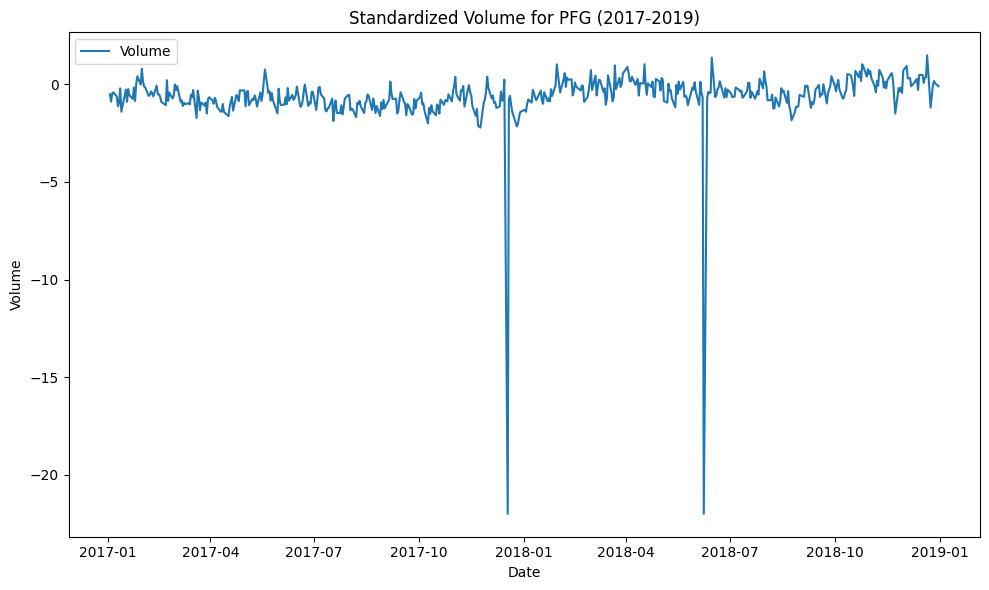

In [51]:
#Visualize an extreme value of the Volume in the test set
pfg = test.loc[(test.index<"2019")&(test.index>="2017")]

plt.figure(figsize=(10, 6))
plt.title("Standardized Volume for PFG (2017-2019)")
plt.plot(pfg.loc[pfg.Ticker == "PFG"].index, pfg.loc[pfg.Ticker == "PFG", "Volume"], label="Volume")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.tight_layout()

# Save the plot as a PDF
plt.savefig("PFG_Volume_2017_2019.png", format="png")
plt.show()

In [52]:
#Check number of extreme values in the test set
test[(test.Dollar_Volume<-30)|(test.Dollar_Volume>30)]

Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2016-01-06  1.480057  1.452667  1.504199  1.476958   1.765304 -23.563329   
2017-12-18  1.596476  1.591169  1.600213  1.597642   2.070207 -22.007681   
2018-06-08  1.044580  1.028260  1.059989  1.045329   1.565305 -22.007681   
2018-06-08  2.745213  2.722538  2.770140  2.745657   2.669071 -33.983817   
2019-10-18 -3.430454 -3.510877 -3.347635 -3.432207  -1.663162 -38.937091   
2019-11-05  1.378952  1.323961  1.431107  1.375583   3.174179 -30.130468   

           Ticker  Dollar_Volume                  Sector    Close_CUM  ...  \
Date                                                                   ...   
2016-01-06    WTW     -33.828542              Financials     4.393087  ...   
2017-12-18    PFG     -40.540687              Financials   453.150710  ...   
2018-06-08    PFG     -40.540687              Financials   608.816603  ...   
2018-06-08    XEL     -35.242845               Utilities  1753.698782  ...   
2019-10-18    BKR     -43.742224                  Energy -1551.027459  ...   
2019-11-05    GEN     -40.861429  Information Technology  1337.085858  ...   

            Consumer Discretionary  Consumer Staples  Energy  Financials  \
Date                                                                       
2016-01-06                     0.0               0.0     0.0         1.0   
2017-12-18                     0.0               0.0     0.0         1.0   
2018-06-08                     0.0               0.0     0.0         1.0   
2018-06-08                     0.0               0.0     0.0         0.0   
2019-10-18                     0.0               0.0     1.0         0.0   
2019-11-05                     0.0               0.0     0.0         0.0   

            Health Care  Industrials  Information Technology  Materials  \
Date                                                                      
2016-01-06          0.0          0.0                     0.0        0.0   
2017-12-18          0.0          0.0                     0.0        0.0   
2018-06-08          0.0          0.0                     0.0        0.0   
2018-06-08          0.0          0.0                     0.0        0.0   
2019-10-18          0.0          0.0                     0.0        0.0   
2019-11-05          0.0          0.0                     1.0        0.0   

            Real Estate  Utilities  
Date                                
2016-01-06          0.0        0.0  
2017-12-18          0.0        0.0  
2018-06-08          0.0        0.0  
2018-06-08          0.0        1.0  
2019-10-18          0.0        0.0  
2019-11-05          0.0        0.0  

[6 rows x 53 columns]

In [53]:
#Check number of extreme values in the training set
train[(train.Dollar_Volume<-10)|(train.Dollar_Volume>10)]

Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2006-07-10 -0.994055 -1.024092 -0.964765 -0.996700  -1.015161 -13.507793   
2006-07-19 -1.044241 -1.074359 -1.014862 -1.046901  -1.063920 -13.507793   
2006-07-31 -0.989662 -1.019692 -0.960379 -0.992306  -1.010892 -13.507793   
2013-12-13  0.597896  0.567332  0.629395  0.597793   0.774941 -15.668164   
2014-03-31  1.518013  1.502123  1.492089  1.473159   1.473183  -7.935275   
2014-04-01  1.479766  1.508885  1.500440  1.520861   1.520890  -8.334447   
2015-01-02 -1.025196 -1.051737 -0.995661 -1.022753  -1.022753 -28.565219   

           Ticker  Dollar_Volume                  Sector   Close_CUM  ...  \
Date                                                                  ...   
2006-07-10    TPL     -13.361005                  Energy -131.987751  ...   
2006-07-19    TPL     -13.361005                  Energy -139.206653  ...   
2006-07-31    TPL     -13.361005                  Energy -147.306872  ...   
2013-12-13   ERIE     -24.020490              Financials -564.109543  ...   
2014-03-31   GOOG     -10.318267  Communication Services -692.180882  ...   
2014-04-01   GOOG     -10.856697  Communication Services -690.660020  ...   
2015-01-02    AMD     -17.866443  Information Technology  296.676586  ...   

            Consumer Discretionary  Consumer Staples  Energy  Financials  \
Date                                                                       
2006-07-10                     0.0               0.0     1.0         0.0   
2006-07-19                     0.0               0.0     1.0         0.0   
2006-07-31                     0.0               0.0     1.0         0.0   
2013-12-13                     0.0               0.0     0.0         1.0   
2014-03-31                     0.0               0.0     0.0         0.0   
2014-04-01                     0.0               0.0     0.0         0.0   
2015-01-02                     0.0               0.0     0.0         0.0   

            Health Care  Industrials  Information Technology  Materials  \
Date                                                                      
2006-07-10          0.0          0.0                     0.0        0.0   
2006-07-19          0.0          0.0                     0.0        0.0   
2006-07-31          0.0          0.0                     0.0        0.0   
2013-12-13          0.0          0.0                     0.0        0.0   
2014-03-31          0.0          0.0                     0.0        0.0   
2014-04-01          0.0          0.0                     0.0        0.0   
2015-01-02          0.0          0.0                     1.0        0.0   

            Real Estate  Utilities  
Date                                
2006-07-10          0.0        0.0  
2006-07-19          0.0        0.0  
2006-07-31          0.0        0.0  
2013-12-13          0.0        0.0  
2014-03-31          0.0        0.0  
2014-04-01          0.0        0.0  
2015-01-02          0.0        0.0  

[7 rows x 53 columns]

In [54]:
def compute_metrics(y_pred, y_true, baseline = False):
    
    results = {}
    
    # 1. Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    results['MAE'] = mae

    # 2. Root Mean Squared Error (RMSE)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    results['RMSE'] = rmse
    

    # 3. Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    results['MAPE'] = mape

    # 4. Adjusted R-squared
    n = len(y_true)  # number of observations
    
    if baseline:
        p=1   # number of predictors (just the previous day's value, so it's 1)
    elif "Sector" in train.columns:
        p = len(train.drop(["Sector", "Ticker"], axis = 1).columns)
    else:
        p = len(train.drop(["Ticker"], axis = 1).columns)
        
    r2 = r2_score(y_true, y_pred)
        
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    results['Adjusted R-squared'] = adj_r2

    # 5. Residuals Analysis
    residuals = y_true - y_pred
    
    # Calculate quantiles
    lower_bound = np.quantile(residuals, 0.001)
    upper_bound = np.quantile(residuals, 0.999)
    
    # Filter residuals within quantile range
    trimmed_residuals = residuals[(residuals >= lower_bound) & (residuals <= upper_bound)]
    
    results["Trimmed_MAE"] = np.mean(np.abs(trimmed_residuals))
    
    plt.figure(figsize=(8, 6))
    sm.qqplot(trimmed_residuals, line='r', ax=plt.gca())
    plt.title("Residual")
    plt.tight_layout()

    # Save the plot as a PDF
    plt.savefig("residual.png", format="png")
    plt.show()
    
    # Also compute the residuals mean and variance
    results['Residual Mean'] = np.mean(trimmed_residuals)
    results['Residual Variance'] = np.var(trimmed_residuals)

    return results

# BASELINE

In [61]:
random_tickers = random.sample(tickers, 5)

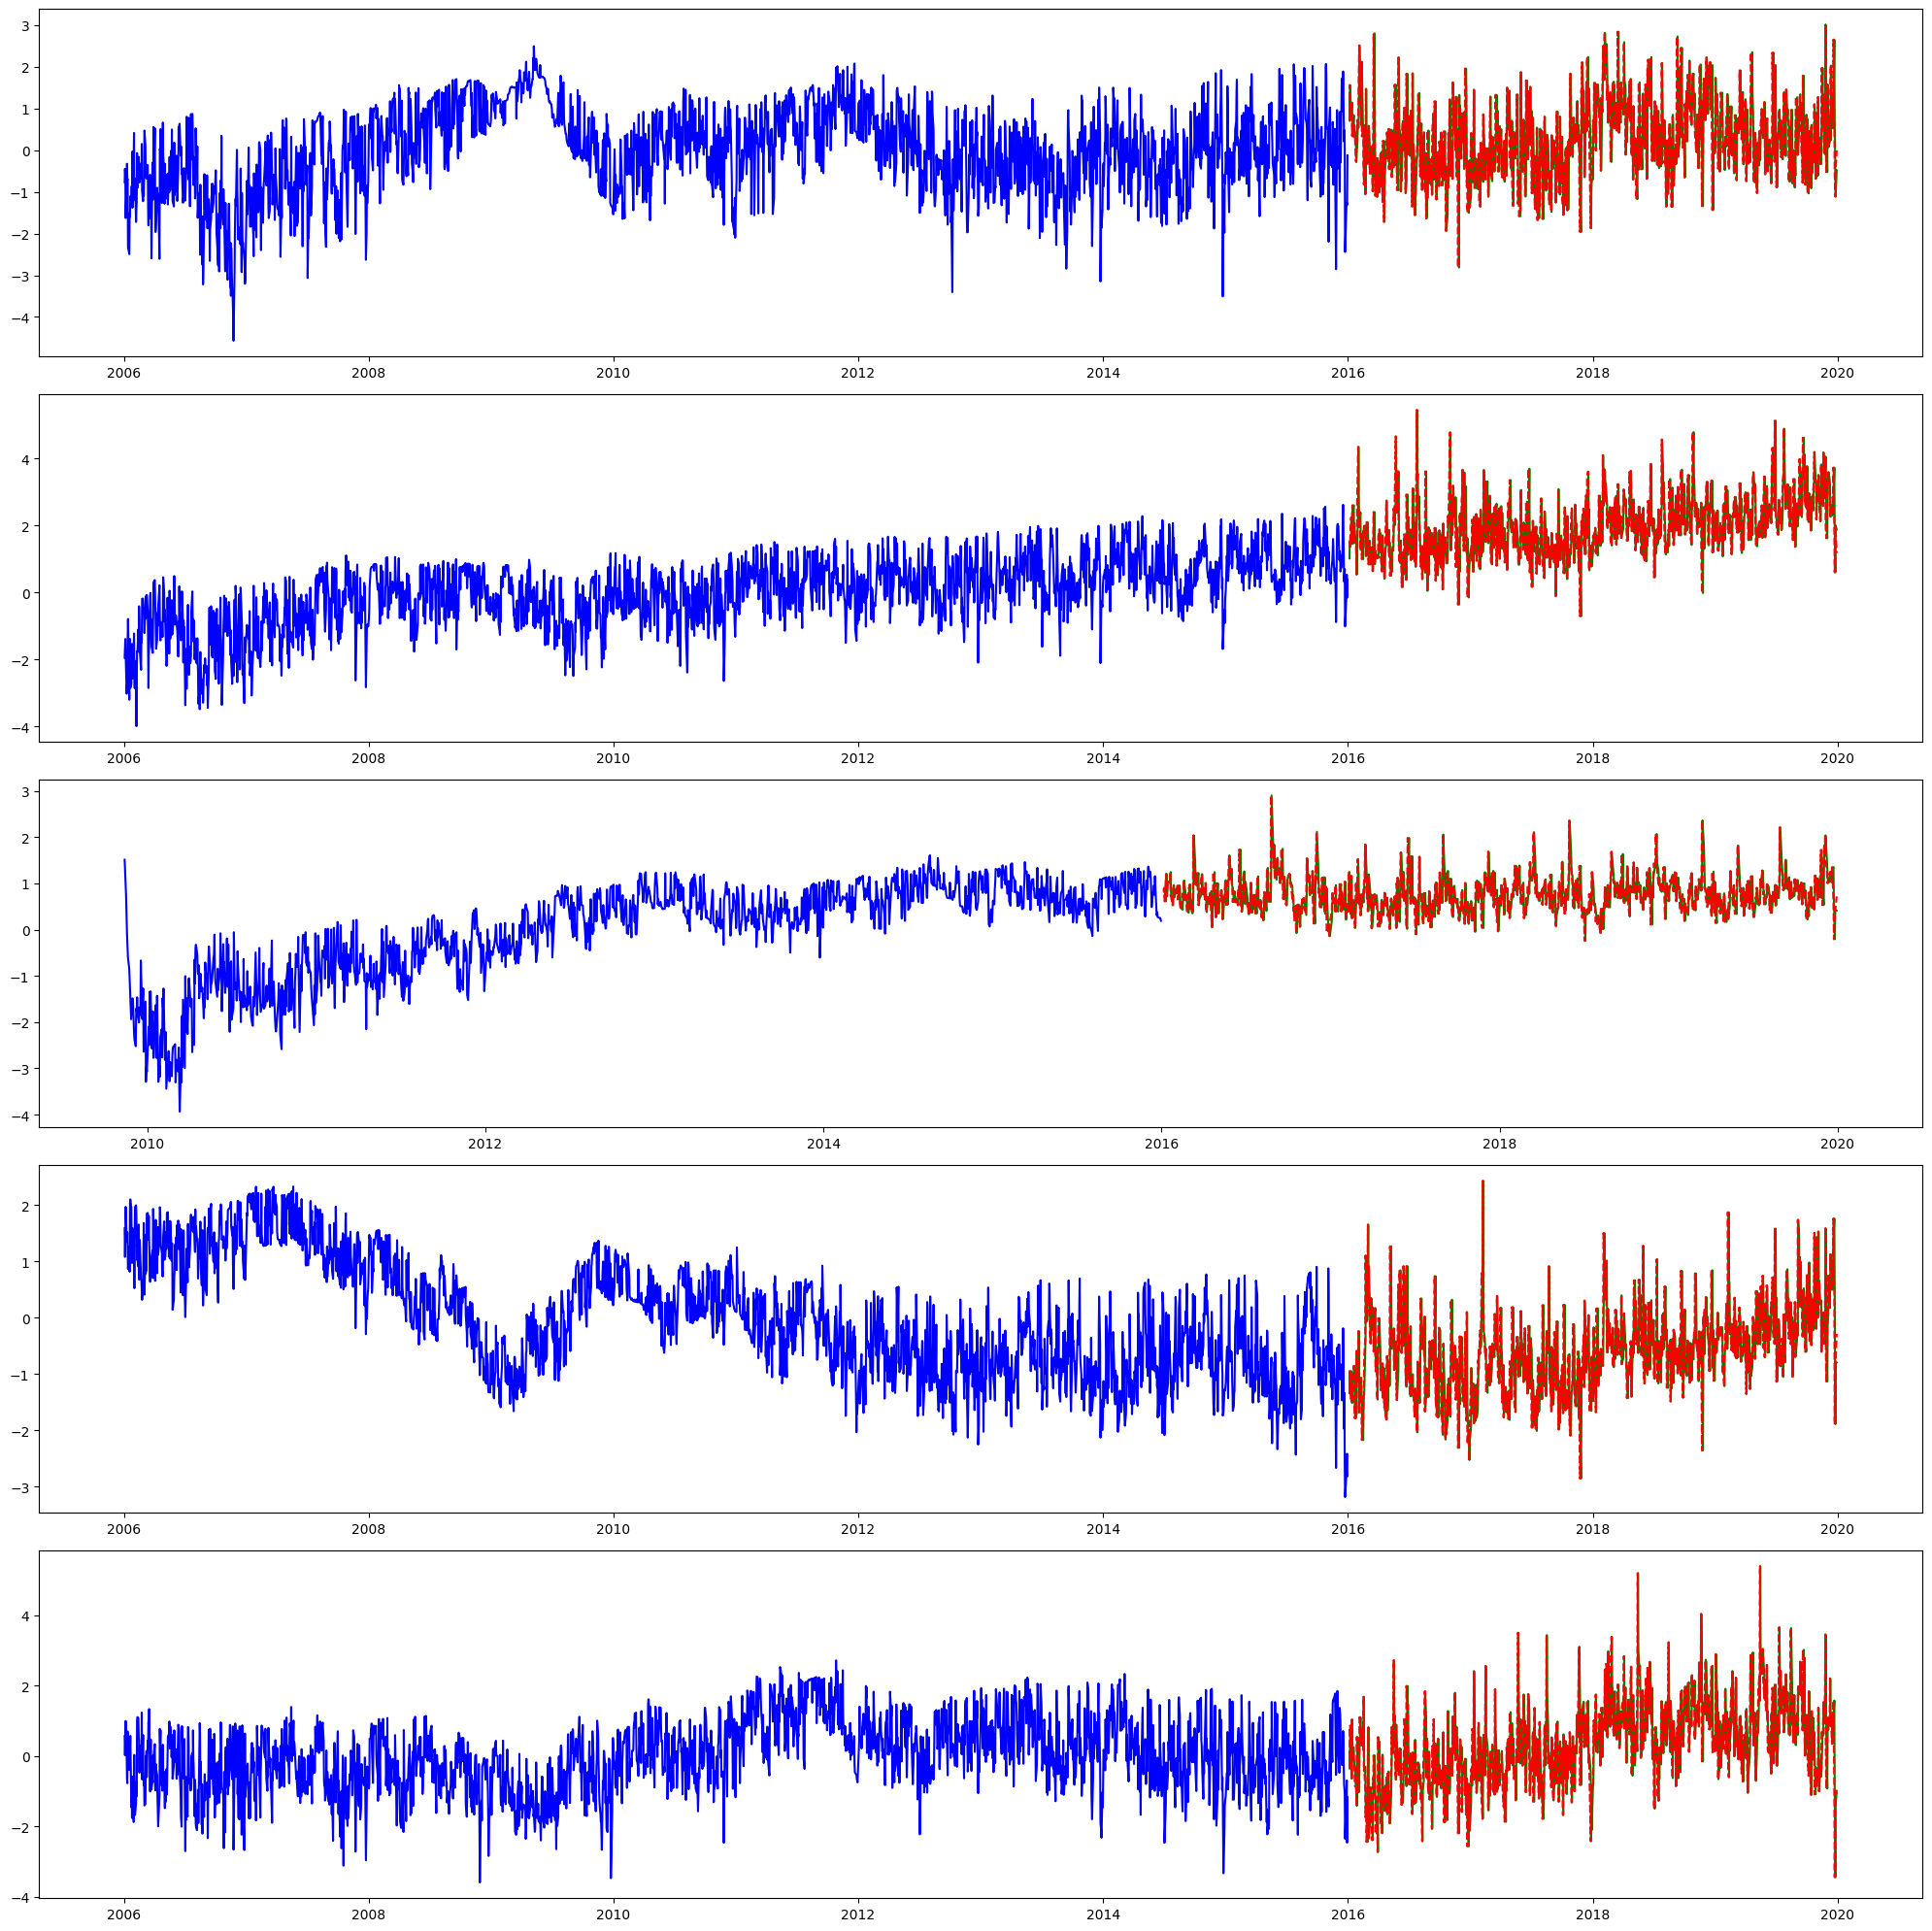

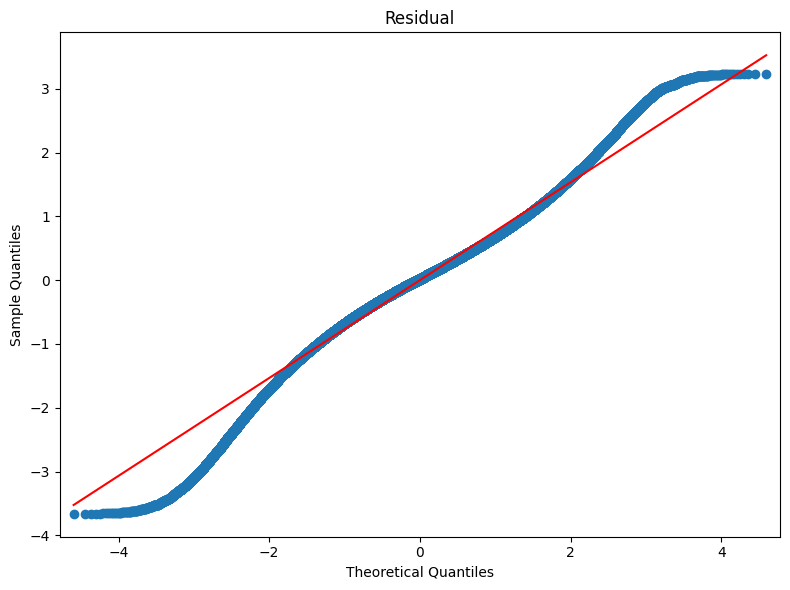

{'MAE': 0.585425448549963, 'RMSE': 0.8263974336735128, 'MAPE': 348.62866765231956, 'Adjusted R-squared': 0.5723174200581793, 'Trimmed_MAE': 0.5771033620675388, 'Residual Mean': 0.0014285493839971547, 'Residual Variance': 0.5983496416761677}


In [62]:
#Baseline is to take the stock's previous dollar volume as prediction
def compute_baseline_metrics(train, test):
    train = train.copy()
    test = test.copy()

    # Initialize a column for the baseline prediction (previous day's Dollar_Volume)
    test['Predicted_Dollar_Volume'] = test.groupby('Ticker')['Dollar_Volume'].shift(1)

    # Remove the first row for each ticker (no previous value to predict from)
    test = test.dropna(subset=['Predicted_Dollar_Volume'])

    # Actual and Predicted values
    y_true = test['Dollar_Volume']
    y_pred = test['Predicted_Dollar_Volume']
    y_train = train["Dollar_Volume"]
    
    figure, axes = plt.subplots(5,1, figsize=(20, 20))
    axes = axes.flatten()
    i = 0
    
    for ticker in random_tickers:
    
        ticker_train = train.loc[train.Ticker==ticker]
        ticker_test = test.loc[test.Ticker==ticker]

        # Plot the training data
        axes[i].plot(ticker_train.index, ticker_train["Dollar_Volume"], label="Train Ground Truth", color="blue")
        
        #Plot the test ground truth
        axes[i].plot(ticker_test.index[1:], ticker_test["Dollar_Volume"][:-1], label="Test Ground Truth", color="green")

        #Plot the predictions
        axes[i].plot(ticker_test.index[1:], ticker_test["Dollar_Volume"][1:], label="Predictions", color="red", linestyle="--")
        i+=1
        
    plt.tight_layout()
    plt.show()

    return compute_metrics(y_true, y_pred)

metrics = compute_baseline_metrics(train, test)
print(metrics)

# LASSO

In [63]:
def create_sequence(train, sequence_length=5):
    """
    Create sequences for time-series data, considering the past sequence_length days for the same ticker.

    Parameters:
        train (pd.DataFrame): Input DataFrame with "Ticker" as an attribute and "Dollar_Volume" as a target.

    Returns:
        pd.DataFrame, pd.Series: Features and targets for the sequences.
    """
    sequences = []
    targets = []
    tickers = train["Ticker"].unique()

    for ticker in tickers:
        ticker_data = train[train["Ticker"] == ticker]
        if "Sector" in train.columns:
            ticker_features = ticker_data.drop(["Ticker", "Sector"], axis=1).values
        else:
            ticker_features = ticker_data.drop(["Ticker"], axis=1).values
        
        ticker_target = ticker_data["Dollar_Volume"].values

        for i in range(sequence_length, len(ticker_data)):
            seq_features = ticker_features[i-sequence_length:i].flatten()  # Flatten past 5 days into one array
            target = ticker_target[i]
            sequences.append(seq_features)
            targets.append(target)

    X_seq = np.array(sequences)
    y_seq = np.array(targets)
    return X_seq, y_seq

In [64]:
def Pipeline_Lasso(train, test, sequence_length=1):
    """
    Pipeline to preprocess data, create sequences, train a Lasso regression model, and compute evaluation metrics.

    Parameters:
        train (pd.DataFrame): Training dataset with features, "Ticker", and "Dollar_Volume".
        test (pd.DataFrame): Test dataset with features, "Ticker", and "Dollar_Volume".
        sequence_length (int): Number of past days to include in the sequence.
        
    Returns:
        dict: Evaluation metrics from compute_metrics function.
    """
    # Create sequences for train and test
    X_train, y_train = create_sequence(train, sequence_length=sequence_length)
    X_test, y_test = create_sequence(test, sequence_length=sequence_length)

    # Apply log transformation to features

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train Lasso regression
    lasso = Lasso(alpha=0.0001)
    lasso.fit(X_train, y_train)

    # Predict and compute metrics
    y_pred = lasso.predict(X_test)
    
    # Get feature names
    if "Sector" in train.columns:
        features = train.drop(["Ticker", "Sector"], axis=1).columns.tolist()
    else:
        features = train.drop(["Ticker"], axis=1).columns.tolist()
        
    # Plot feature importance if sequence_length == 1
    if sequence_length == 1:
        coefficients = pd.Series(lasso.coef_, index=features)

        # Select top 15 features by absolute coefficient magnitude
        top_features = coefficients.abs().nlargest(15)

        # Plot feature importance (vertical bar plot)
        plt.figure(figsize=(8, len(top_features) * 0.5))
        top_features.sort_values().plot(kind='barh', color='orange')  # Sort to display highest importance at the top
        plt.title("Top 15 Feature Importances (Lasso)")
        plt.xlabel("Coefficient Magnitude")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.savefig("lasso_feature_importance.png", format="png")
        plt.show()
    
    return compute_metrics(y_pred, y_test), lasso


In [65]:
def Pipeline_Lasso_CV(train, test, sequence_length=1):
    """
    Pipeline to preprocess data, create sequences, train a Lasso regression model, and compute evaluation metrics.
    
    Parameters:
        train (pd.DataFrame): Training dataset with features, "Ticker", and "Dollar_Volume".
        test (pd.DataFrame): Test dataset with features, "Ticker", and "Dollar_Volume".
        sequence_length (int): Number of past days to include in the sequence.

    Returns:
        dict: Evaluation metrics from compute_metrics function.
    """
    # Create sequences for train and test
    X_train, y_train = create_sequence(train, sequence_length=sequence_length)
    X_test, y_test = create_sequence(test, sequence_length=sequence_length)

    # Apply log transformation to features

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Set up Lasso and grid search for hyperparameter tuning (alpha selection)
    lasso = Lasso()
    param_grid = {'alpha': np.logspace(-6, -2, 20)}  # Range of alphas to search

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Get the best alpha from grid search
    best_alpha = grid_search.best_params_['alpha']
    print(f"Best alpha found: {best_alpha}")

    # Train the final model with the best alpha
    lasso = Lasso(alpha=best_alpha)
    lasso.fit(X_train, y_train)
    

    # Predict and compute metrics
    y_pred = lasso.predict(X_test)
    return compute_metrics(y_pred, y_test)


In [66]:
raw_train = train[["Open", "Close", "High", "Low", "Adj Close", "Volume", "Dollar_Volume", "Ticker"]]
raw_test = test[["Open", "Close", "High", "Low", "Adj Close", "Volume", "Dollar_Volume", "Ticker"]]

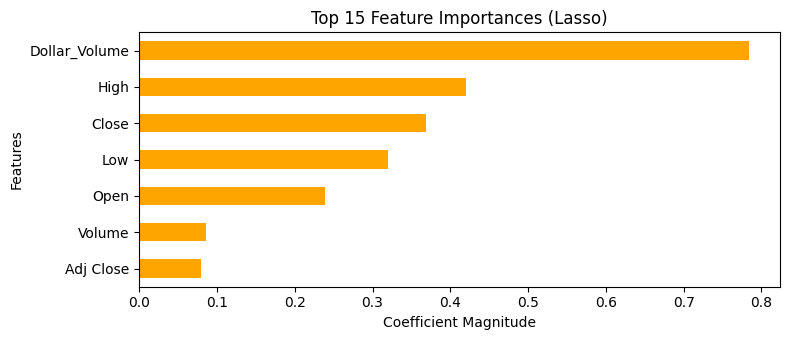

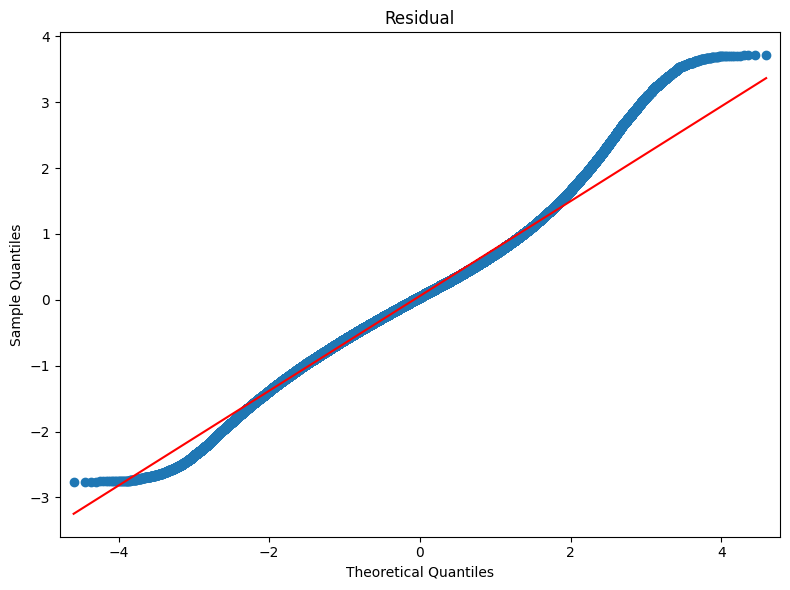

{'MAE': 0.556011496859713, 'RMSE': 0.7725813932289366, 'MAPE': 304.05709925561837, 'Adjusted R-squared': 0.626509615355584, 'Trimmed_MAE': 0.5483742709053382, 'Residual Mean': 0.05885490548888333, 'Residual Variance': 0.5249550276429992}


In [67]:
#Lasso with raw features
result, _ = Pipeline_Lasso(raw_train, raw_test)
print(result)

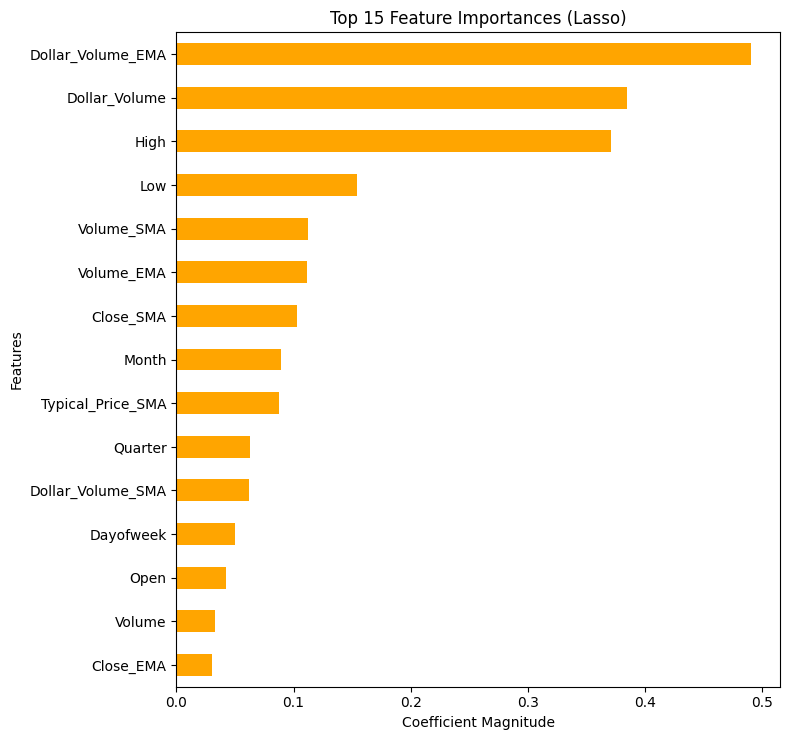

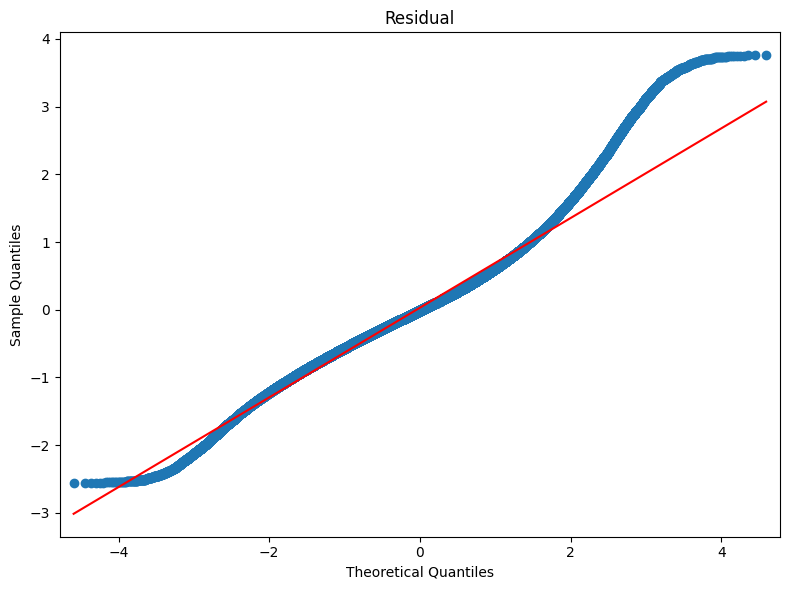

{'MAE': 0.5055017238470862, 'RMSE': 0.7160428433542657, 'MAPE': 287.4892977525146, 'Adjusted R-squared': 0.679174445468751, 'Trimmed_MAE': 0.49799237378717853, 'Residual Mean': 0.029542521081290254, 'Residual Variance': 0.4512168773612728}


In [68]:
#Lasso with augmented features, sequence_length=1
result, _ = Pipeline_Lasso(train, test)
print(result)

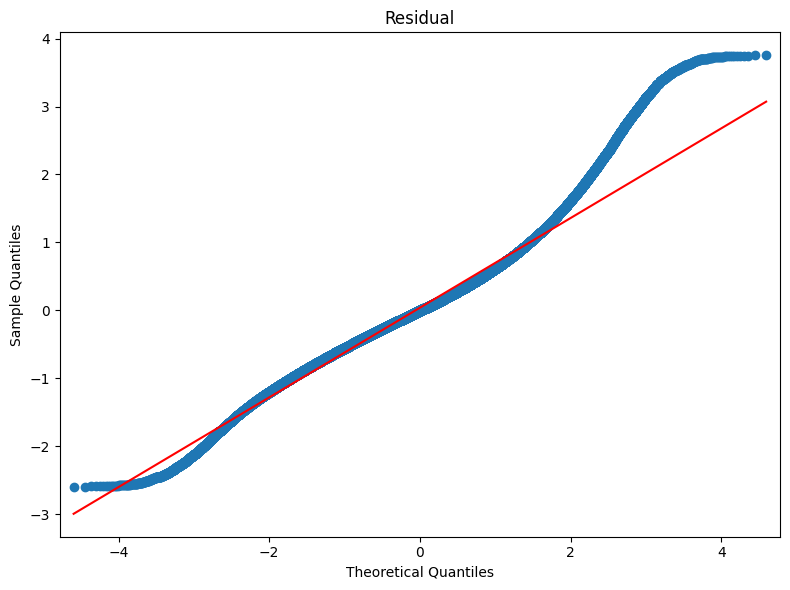

{'MAE': 0.5037721713350003, 'RMSE': 0.7122163075724277, 'MAPE': 288.23174841828984, 'Adjusted R-squared': 0.6823457662472405, 'Trimmed_MAE': 0.4963044161484879, 'Residual Mean': 0.03780855964392623, 'Residual Variance': 0.4489934360003999}


In [69]:
#Lasso with augmented features, sequence_length=3
result, lasso = Pipeline_Lasso(train, test, sequence_length=3)
print(result)

# LINEAR+PCA

In [70]:
from sklearn.decomposition import PCA

def Pipeline_LR_PCA(train, test, sequence_length=1):
    """
    Pipeline to preprocess data, create sequences, train a Lasso regression model, and compute evaluation metrics.

    Parameters:
        train (pd.DataFrame): Training dataset with features, "Ticker", and "Dollar_Volume".
        test (pd.DataFrame): Test dataset with features, "Ticker", and "Dollar_Volume".
        sequence_length (int): Number of past days to include in the sequence.
        
    Returns:
        dict: Evaluation metrics from compute_metrics function.
    """
    # Create sequences for train and test
    X_train, y_train = create_sequence(train, sequence_length=sequence_length)
    X_test, y_test = create_sequence(test, sequence_length=sequence_length)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=20)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    # Train Lasso regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Predict and compute metrics
    y_pred = lr.predict(X_test)

    # Plot feature importance if sequence_length == 1
    if sequence_length == 1:
        # Coefficients correspond to PCA components
        coefficients = pd.Series(lr.coef_, index=[f"PC{i+1}" for i in range(20)])

        # Select top 10 features by absolute coefficient magnitude
        top_features = coefficients.abs().nlargest(20)

        # Plot feature importance (vertical bar plot)
        plt.figure(figsize=(8, len(top_features) * 0.5))
        top_features.sort_values().plot(kind='barh', color='orange')  # Sort to display highest importance at the top
        plt.title("Top 15 Feature Importances (Linear Regression with PCA)")
        plt.xlabel("Coefficient Magnitude")
        plt.ylabel("Principal Components")
        plt.tight_layout()
        plt.show()

    return compute_metrics(y_pred, y_test)


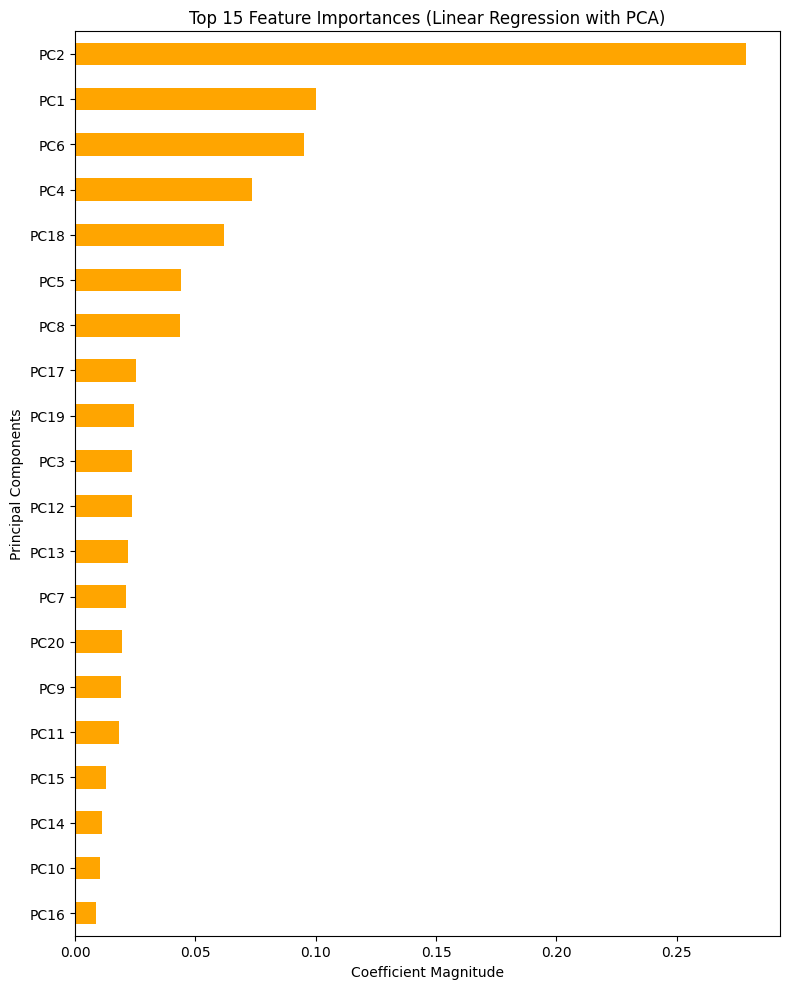

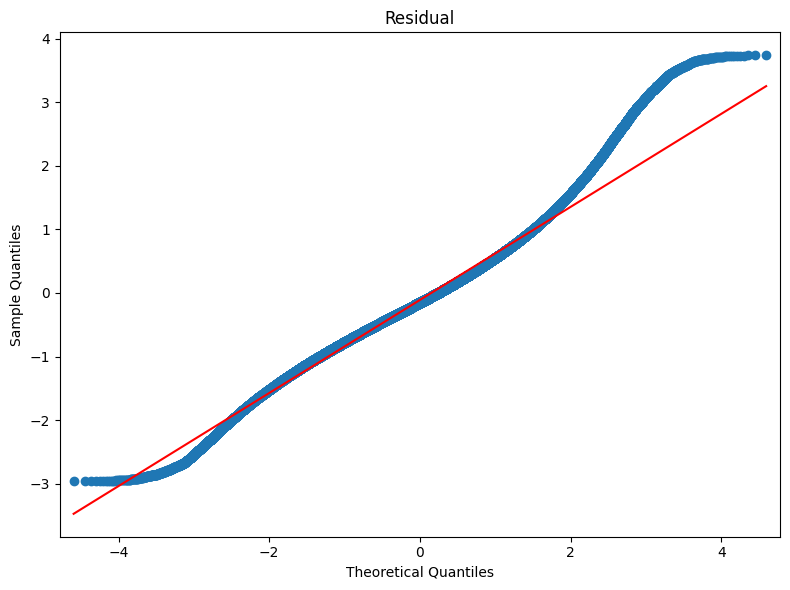

{'MAE': 0.5787416453652499,
 'RMSE': 0.7873163438075093,
 'MAPE': 352.7608902309434,
 'Adjusted R-squared': 0.6121270701312682,
 'Trimmed_MAE': 0.5710525268243901,
 'Residual Mean': -0.1099840728401774,
 'Residual Variance': 0.5461195987650048}

In [71]:
#Linear with augmented features+PCA, sequence_length=1
Pipeline_LR_PCA(train, test, sequence_length=1)

# XGBOOST

In [72]:
def Pipeline_XGBoost(train, test, sequence_length=5, early_stopping_rounds=5, validation_split=0.1):
    """
    Pipeline to preprocess data, create sequences, train an XGBoost model, and compute evaluation metrics.

    Parameters:
        train (pd.DataFrame): Training dataset with features, "Ticker", and "Dollar_Volume".
        test (pd.DataFrame): Test dataset with features, "Ticker", and "Dollar_Volume".
        sequence_length (int): Number of past days to include in the sequence.
        early_stopping_rounds (int): Number of rounds for early stopping (default is 10).
        
    Returns:
        dict: Evaluation metrics from compute_metrics function.
    """
    # Create sequences for train and test
    X_train, y_train = create_sequence(train, sequence_length=sequence_length)
    X_test, y_test = create_sequence(test, sequence_length=sequence_length)

    # Create a validation set (you can use a separate validation dataset if available)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_split, shuffle=True, random_state=0)
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    # Set XGBoost parameters
    params = {
        'objective': 'reg:squarederror',  # Regression task
        'eval_metric': 'rmse',  # Root Mean Squared Error evaluation
        'eta': 0.05,  # Learning rate
        'max_depth': 5,  # Maximum depth of the tree
        'subsample': 0.8,  # Subsample ratio
        'colsample_bytree': 0.8,  # Column subsampling
        'n_jobs': -1
    }

    # Train the XGBoost model with early stopping
    num_round = 200  # Number of boosting rounds
    evals = [(dtrain, 'train'), (dval, 'eval')]
    bst = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=early_stopping_rounds)

    # Make predictions on the test set
    y_pred = bst.predict(dtest)

    if sequence_length == 1:
        
        # Plot feature importance
        features = train.drop(["Ticker", "Sector"], axis=1).columns.tolist()
        feature_importance = bst.get_score(importance_type='weight')
        sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

        feature_names = [features[int(key[1:])] for key, _ in sorted_importance]
        importance_values = [value for _, value in sorted_importance]

        plt.figure(figsize=(10, 6))
        plt.barh(feature_names[::-1], importance_values[::-1], color='orange')  # Reverse to display top features at the top
        plt.title("Feature Importance (XGBoost)")
        plt.xlabel("Importance Score")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.savefig("xgboost_feature_importance.png", format="png")
        plt.show()

    # Compute and return metrics
    return compute_metrics(y_pred, y_test), bst



[0]	train-rmse:1.07921	eval-rmse:1.07952
[1]	train-rmse:1.04455	eval-rmse:1.04488
[2]	train-rmse:1.01221	eval-rmse:1.01260
[3]	train-rmse:0.98132	eval-rmse:0.98179
[4]	train-rmse:0.95253	eval-rmse:0.95308
[5]	train-rmse:0.92569	eval-rmse:0.92636
[6]	train-rmse:0.90078	eval-rmse:0.90154
[7]	train-rmse:0.87765	eval-rmse:0.87851
[8]	train-rmse:0.85620	eval-rmse:0.85714
[9]	train-rmse:0.83676	eval-rmse:0.83776
[10]	train-rmse:0.81831	eval-rmse:0.81942
[11]	train-rmse:0.80122	eval-rmse:0.80242
[12]	train-rmse:0.78542	eval-rmse:0.78671
[13]	train-rmse:0.77090	eval-rmse:0.77228
[14]	train-rmse:0.75752	eval-rmse:0.75901
[15]	train-rmse:0.74548	eval-rmse:0.74704
[16]	train-rmse:0.73403	eval-rmse:0.73569
[17]	train-rmse:0.72353	eval-rmse:0.72524
[18]	train-rmse:0.71390	eval-rmse:0.71571
[19]	train-rmse:0.70506	eval-rmse:0.70695
[20]	train-rmse:0.69699	eval-rmse:0.69897
[21]	train-rmse:0.68957	eval-rmse:0.69164
[22]	train-rmse:0.68279	eval-rmse:0.68490
[23]	train-rmse:0.67655	eval-rmse:0.67871
[2

[194]	train-rmse:0.58077	eval-rmse:0.58605
[195]	train-rmse:0.58073	eval-rmse:0.58601
[196]	train-rmse:0.58065	eval-rmse:0.58594
[197]	train-rmse:0.58055	eval-rmse:0.58585
[198]	train-rmse:0.58051	eval-rmse:0.58583
[199]	train-rmse:0.58046	eval-rmse:0.58580


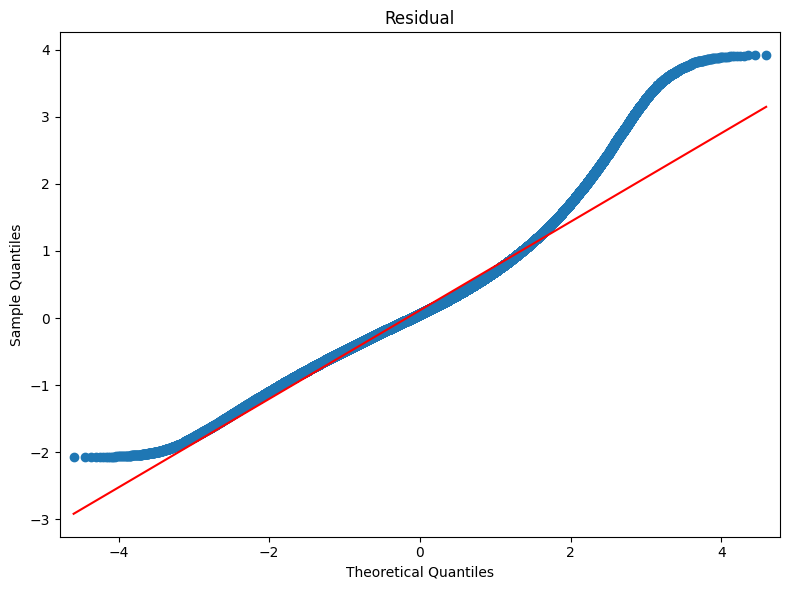

{'MAE': 0.5085447421589885, 'RMSE': 0.717618718416869, 'MAPE': 262.16807488334945, 'Adjusted R-squared': 0.6775084513346243, 'Trimmed_MAE': 0.5017036101656773, 'Residual Mean': 0.11497059782814968, 'Residual Variance': 0.4501765098823334}


In [73]:
result, xgb_model = Pipeline_XGBoost(train, test, sequence_length=3)
print(result)

# FEED-FORWARD NEURAL NETWORK

In [74]:
def set_random_seed(seed=0):
    """
    Set random seed for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [75]:
def Pipeline_FFN(train, test, sequence_length=5, validation_split=0.1, epochs=100, batch_size=1024, patience=10):
    """
    Pipeline to preprocess data, create sequences, train a feedforward neural network (FFN) with early stopping, 
    and compute evaluation metrics.

    Parameters:
        train (pd.DataFrame): Training dataset with features, "Ticker", and "Dollar_Volume".
        test (pd.DataFrame): Test dataset with features, "Ticker", and "Dollar_Volume".
        sequence_length (int): Number of past days to include in the sequence.
        validation_split (float): Fraction of the training data to use for validation (default is 0.2).
        epochs (int): Number of epochs for training (default is 100).
        batch_size (int): Batch size for training (default is 32).
        patience (int): Number of epochs to wait for improvement before stopping (default is 5).

    Returns:
        dict: Evaluation metrics from compute_metrics function.
    """
    set_random_seed()

    # Create sequences for train and test
    X_train, y_train = create_sequence(train, sequence_length=sequence_length)
    X_test, y_test = create_sequence(test, sequence_length=sequence_length)

    # Scale data
    scaler = StandardScaler()
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_split, shuffle=True, random_state = 0)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    input_dim = X_train.shape[1]

    # Define FFN model
    model = Sequential([
        Dense(48, activation='relu', input_shape=(input_dim,)),
        Dropout(0.6),
        Dense(1)  # Output layer for regression
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

    # Early stopping callback
    early_stop = EarlyStopping(
        monitor='val_loss',  # Monitor validation loss for early stopping
        patience=patience,   # Number of epochs with no improvement to stop training
        restore_best_weights=True  # Restore weights from the best epoch
    )

    # Train the model with early stopping
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Compute and return metrics
    return compute_metrics(y_pred.flatten(), y_test), model

Epoch 1/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9141 - mae: 0.6960 - val_loss: 0.3817 - val_mae: 0.4778
Epoch 2/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4231 - mae: 0.5063 - val_loss: 0.3774 - val_mae: 0.4744
Epoch 3/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4175 - mae: 0.5027 - val_loss: 0.3766 - val_mae: 0.4742
Epoch 4/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4143 - mae: 0.5007 - val_loss: 0.3755 - val_mae: 0.4731
Epoch 5/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4134 - mae: 0.5001 - val_loss: 0.3759 - val_mae: 0.4741
Epoch 6/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4118 - mae: 0.4995 - val_loss: 0.3742 - val_mae: 0.4725
Epoch 7/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4126 - mae: 0.4997 - val_loss: 0.3734 - val_mae: 0.4723
Epoch 8/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4111 - mae: 0.4989 - val_loss: 0.3728 - val_mae: 0.4718
Epoch 9/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/

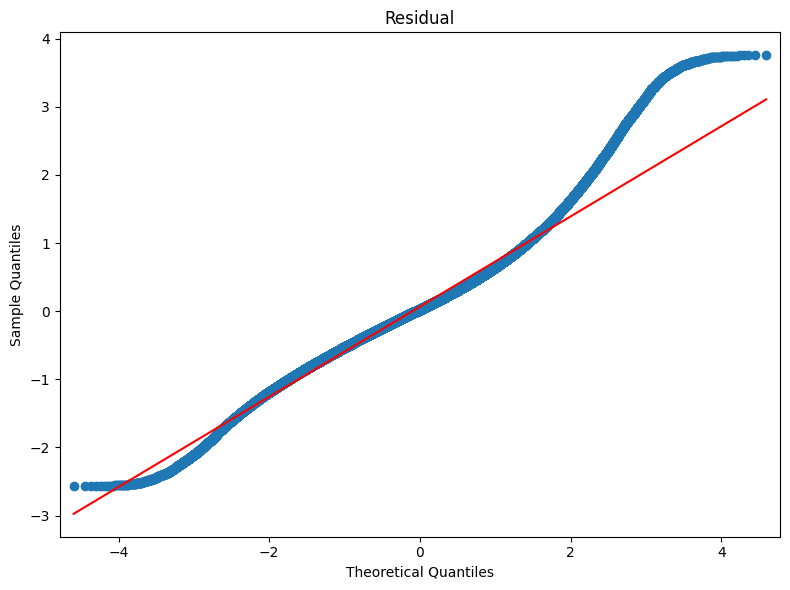

{'MAE': 0.5058211333008675, 'RMSE': 0.7140043169764415, 'MAPE': 276.2330573013246, 'Adjusted R-squared': 0.6807488309059164, 'Trimmed_MAE': 0.4984612796648083, 'Residual Mean': 0.06718829157261359, 'Residual Variance': 0.45024389675233734}


In [76]:
result, FFN = Pipeline_FFN(train, test, sequence_length=3)
print(result)

In [77]:
def create_sequence_shift(train, sequence_length=5):
    """
    Create sequences for time-series data, considering the past sequence_length days for the same ticker.

    Parameters:
        train (pd.DataFrame): Input DataFrame with "Ticker" as an attribute and "Dollar_Volume" as a target.

    Returns:
        pd.DataFrame, pd.Series: Features and targets for the sequences.
    """
    sequences = []
    targets = []
    tickers = train["Ticker"].unique()

    for ticker in tickers:
        ticker_data = train[train["Ticker"] == ticker]
        if "Sector" in train.columns:
            ticker_features = ticker_data.drop(["Ticker", "Sector"], axis=1).values
        else:
            ticker_features = ticker_data.drop(["Ticker"], axis=1).values
        
        ticker_target = ticker_data["Dollar_Volume"].values

        for i in range(sequence_length, len(ticker_data)):
            seq_features = ticker_features[i-sequence_length:i].flatten()  # Flatten past 5 days into one array
            target = ticker_target[i-sequence_length+1:i+1].flatten()
            sequences.append(seq_features)
            targets.append(target)

    X_seq = np.array(sequences)
    y_seq = np.array(targets)
    return X_seq, y_seq

In [78]:
def Pipeline_FFN_shift(train, test, sequence_length=3, validation_split=0.1, epochs=100, batch_size=1024, patience=10):
    """
    Pipeline to preprocess data, create sequences, train an LSTM model with early stopping, and compute evaluation metrics.

    Parameters:
        train (pd.DataFrame): Training dataset with features, "Ticker", and "Dollar_Volume".
        test (pd.DataFrame): Test dataset with features, "Ticker", and "Dollar_Volume".
        sequence_length (int): Number of past days to include in the sequence.
        validation_split (float): Fraction of the training data to use for validation (default is 0.2).
        epochs (int): Number of epochs for training (default is 50).
        batch_size (int): Batch size for training (default is 32).
        patience (int): Number of epochs to wait for improvement before stopping (default is 10).

    Returns:
        dict: Evaluation metrics from compute_metrics function.
    """
    set_random_seed()

    # Create sequences for train and test
    X_train, y_train = create_sequence_shift(train, sequence_length=sequence_length)
    X_test, y_test = create_sequence_shift(test, sequence_length=sequence_length)

    # Scale data
    scaler = StandardScaler()
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_split, shuffle=True, random_state = 0)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    input_dim = X_train.shape[1]

    # Define FFN model
    model = Sequential([
        Dense(200, activation='relu', input_shape=(input_dim,)),
        Dropout(0.6),
        Dense(sequence_length)  # Output layer for regression
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

    # Early stopping callback
    early_stop = EarlyStopping(
        monitor='val_loss',  # Monitor validation loss for early stopping
        patience=patience,   # Number of epochs with no improvement to stop training
        restore_best_weights=True  # Restore weights from the best epoch
    )

    # Train the model with early stopping
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    # Make predictions on the test set
    y_pred = model.predict(X_test)[:,-1]

    # Compute and return metrics
    return compute_metrics(y_pred.flatten(), y_test[:,-1]), model

Epoch 1/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4240 - mae: 0.4335 - val_loss: 0.1283 - val_mae: 0.1936
Epoch 2/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1537 - mae: 0.2526 - val_loss: 0.1276 - val_mae: 0.1900
Epoch 3/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1511 - mae: 0.2469 - val_loss: 0.1265 - val_mae: 0.1830
Epoch 4/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1507 - mae: 0.2456 - val_loss: 0.1268 - val_mae: 0.1857
Epoch 5/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1501 - mae: 0.2446 - val_loss: 0.1260 - val_mae: 0.1810
Epoch 6/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1499 - mae: 0.2441 - val_loss: 0.1263 - val_mae: 0.1842
Epoch 7/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1499 - mae: 0.2440 - val_loss: 0.1263 - val_mae: 0.1858
Epoch 8/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1496 - mae: 0.2435 - val_loss: 0.1251 - val_mae: 0.1806
Epoch 9/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/

970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1478 - mae: 0.2421 - val_loss: 0.1233 - val_mae: 0.1848
Epoch 55/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1476 - mae: 0.2416 - val_loss: 0.1236 - val_mae: 0.1846
Epoch 56/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1477 - mae: 0.2418 - val_loss: 0.1228 - val_mae: 0.1806
Epoch 57/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1478 - mae: 0.2421 - val_loss: 0.1231 - val_mae: 0.1823
Epoch 58/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1477 - mae: 0.2417 - val_loss: 0.1227 - val_mae: 0.1796
Epoch 59/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1477 - mae: 0.2419 - val_loss: 0.1230 - val_mae: 0.1804
Epoch 60/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1476 - mae: 0.2417 - val_loss: 0.1233 - val_mae: 0.1847
Epoch 61/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1476 - mae: 0.2418 - val_loss: 0.1223 - val_mae: 0.1760
Epoch 62/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

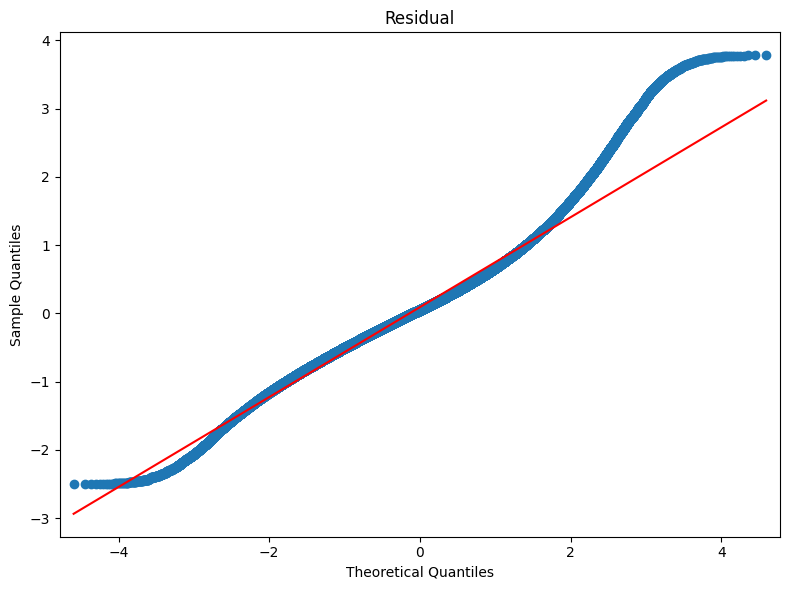

{'MAE': 0.5056234405974915, 'RMSE': 0.7135420061639176, 'MAPE': 275.37024287673336, 'Adjusted R-squared': 0.6811621210815536, 'Trimmed_MAE': 0.4982893251924488, 'Residual Mean': 0.0906713642519631, 'Residual Variance': 0.4462902168628928}


In [79]:
result, FFN_shift = Pipeline_FFN_shift(train, test, sequence_length=3)
print(result)

In [80]:
def create_sequence_shift_all(train, sequence_length=5):
    """
    Create sequences for time-series data, considering the past sequence_length days for the same ticker.

    Parameters:
        train (pd.DataFrame): Input DataFrame with "Ticker" as an attribute and "Dollar_Volume" as a target.

    Returns:
        pd.DataFrame, pd.Series: Features and targets for the sequences.
    """
    sequences = []
    targets = []
    tickers = train["Ticker"].unique()

    for ticker in tickers:
        ticker_data = train[train["Ticker"] == ticker]
        if "Sector" in train.columns:
            ticker_features = ticker_data.drop(["Ticker", "Sector"], axis=1).values
        else:
            ticker_features = ticker_data.drop(["Ticker"], axis=1).values
        
        ticker_target = ticker_data[["Close", "Volume", "Dollar_Volume"]].values

        for i in range(sequence_length, len(ticker_data)):
            seq_features = ticker_features[i-sequence_length:i].flatten()  # Flatten past 5 days into one array
            target = ticker_target[i-sequence_length+1:i+1].flatten()
            sequences.append(seq_features)
            targets.append(target)

    X_seq = np.array(sequences)
    y_seq = np.array(targets)
    return X_seq, y_seq

In [81]:
def Pipeline_FFN_shift_all(train, test, sequence_length=3, validation_split=0.1, epochs=100, batch_size=1024, patience=10):
    """
    Pipeline to preprocess data, create sequences, train an LSTM model with early stopping, and compute evaluation metrics.

    Parameters:
        train (pd.DataFrame): Training dataset with features, "Ticker", and "Dollar_Volume".
        test (pd.DataFrame): Test dataset with features, "Ticker", and "Dollar_Volume".
        sequence_length (int): Number of past days to include in the sequence.
        validation_split (float): Fraction of the training data to use for validation (default is 0.2).
        epochs (int): Number of epochs for training (default is 50).
        batch_size (int): Batch size for training (default is 32).
        patience (int): Number of epochs to wait for improvement before stopping (default is 10).

    Returns:
        dict: Evaluation metrics from compute_metrics function.
    """
    set_random_seed()

    # Create sequences for train and test
    X_train, y_train = create_sequence_shift_all(train, sequence_length=sequence_length)
    X_test, y_test = create_sequence_shift_all(test, sequence_length=sequence_length)

    # Scale data
    scaler = StandardScaler()
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_split, shuffle=True, random_state = 0)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    input_dim = X_train.shape[1]

    # Define FFN model
    model = Sequential([
        Dense(300, activation='relu', input_shape=(input_dim,)),
        Dropout(0.6),
        Dense(sequence_length*3)  # Output layer for regression
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

    # Early stopping callback
    early_stop = EarlyStopping(
        monitor='val_loss',  # Monitor validation loss for early stopping
        patience=patience,   # Number of epochs with no improvement to stop training
        restore_best_weights=True  # Restore weights from the best epoch
    )

    # Train the model with early stopping
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    # Make predictions on the test set
    y_pred = model.predict(X_test)[:,-1]

    # Compute and return metrics
    return compute_metrics(y_pred.flatten(), y_test[:,-1]), model

Epoch 1/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3043 - mae: 0.3656 - val_loss: 0.0881 - val_mae: 0.1465
Epoch 2/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1178 - mae: 0.2202 - val_loss: 0.0877 - val_mae: 0.1439
Epoch 3/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1160 - mae: 0.2168 - val_loss: 0.0882 - val_mae: 0.1475
Epoch 4/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1159 - mae: 0.2164 - val_loss: 0.0875 - val_mae: 0.1432
Epoch 5/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1158 - mae: 0.2161 - val_loss: 0.0872 - val_mae: 0.1419
Epoch 6/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1157 - mae: 0.2160 - val_loss: 0.0871 - val_mae: 0.1435
Epoch 7/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1156 - mae: 0.2160 - val_loss: 0.0869 - val_mae: 0.1439
Epoch 8/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1154 - mae: 0.2158 - val_loss: 0.0859 - val_mae: 0.1387
Epoch 9/100
970/970 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/

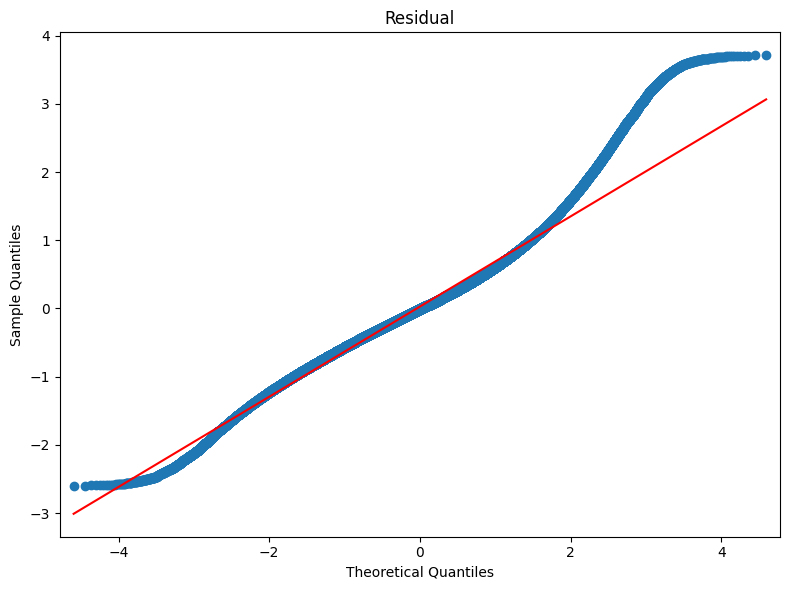

{'MAE': 0.5050401639741466, 'RMSE': 0.7102169317783127, 'MAPE': 303.89003336588974, 'Adjusted R-squared': 0.6841267384593583, 'Trimmed_MAE': 0.4976791762410553, 'Residual Mean': 0.026897302546068154, 'Residual Variance': 0.449156402286093}


In [82]:
result, FFN_shift_all = Pipeline_FFN_shift_all(train, test, sequence_length=3)
print(result)

# LSTM

In [83]:
def Pipeline_LSTM(train, test, sequence_length=5, validation_split=0.1, epochs=50, batch_size=1024, patience=10):
    """
    Pipeline to preprocess data, create sequences, train an LSTM model with early stopping, and compute evaluation metrics.

    Parameters:
        train (pd.DataFrame): Training dataset with features, "Ticker", and "Dollar_Volume".
        test (pd.DataFrame): Test dataset with features, "Ticker", and "Dollar_Volume".
        sequence_length (int): Number of past days to include in the sequence.
        validation_split (float): Fraction of the training data to use for validation (default is 0.2).
        epochs (int): Number of epochs for training (default is 50).
        batch_size (int): Batch size for training (default is 32).
        patience (int): Number of epochs to wait for improvement before stopping (default is 10).

    Returns:
        dict: Evaluation metrics from compute_metrics function.
    """
    set_random_seed()
    
    # Create sequences for train and test
    X_train, y_train = create_sequence(train, sequence_length=sequence_length)
    X_test, y_test = create_sequence(test, sequence_length=sequence_length)

    # Scale data
    scaler = StandardScaler()
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_split, shuffle=False)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Reshape data to 3D for LSTM: (samples, timesteps, features)
    X_train = X_train.reshape(-1, sequence_length, X_train.shape[-1] // sequence_length)
    X_val = X_val.reshape(-1, sequence_length, X_val.shape[-1] // sequence_length)
    X_test = X_test.reshape(-1, sequence_length, X_test.shape[-1] // sequence_length)

    # Define LSTM model
    model = Sequential([
        LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),  # Single LSTM layer
        Dropout(0.6),  # Regularization
        Dense(1)  # Output layer for regression
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

    # Early stopping callback
    early_stop = EarlyStopping(
        monitor='val_loss',  # Monitor validation loss for early stopping
        patience=patience,   # Number of epochs with no improvement to stop training
        restore_best_weights=True  # Restore weights from the best epoch
    )

    # Train the model with early stopping
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Compute and return metrics
    return compute_metrics(y_pred.flatten(), y_test)

Epoch 1/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.5746 - mae: 0.5886 - val_loss: 0.2984 - val_mae: 0.4123
Epoch 2/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4185 - mae: 0.5041 - val_loss: 0.2964 - val_mae: 0.4115
Epoch 3/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4137 - mae: 0.5008 - val_loss: 0.2950 - val_mae: 0.4106
Epoch 4/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4121 - mae: 0.5001 - val_loss: 0.2932 - val_mae: 0.4095
Epoch 5/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4106 - mae: 0.4992 - val_loss: 0.2938 - val_mae: 0.4106
Epoch 6/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4094 - mae: 0.4988 - val_loss: 0.2920 - val_mae: 0.4094
Epoch 7/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4080 - mae: 0.4984 - val_loss: 0.2898 - val_mae: 0.4077
Epoch 8/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4062 - mae: 0.4971 - val_loss: 0.2894 - val_mae: 0.4081
Epoch 9/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lo

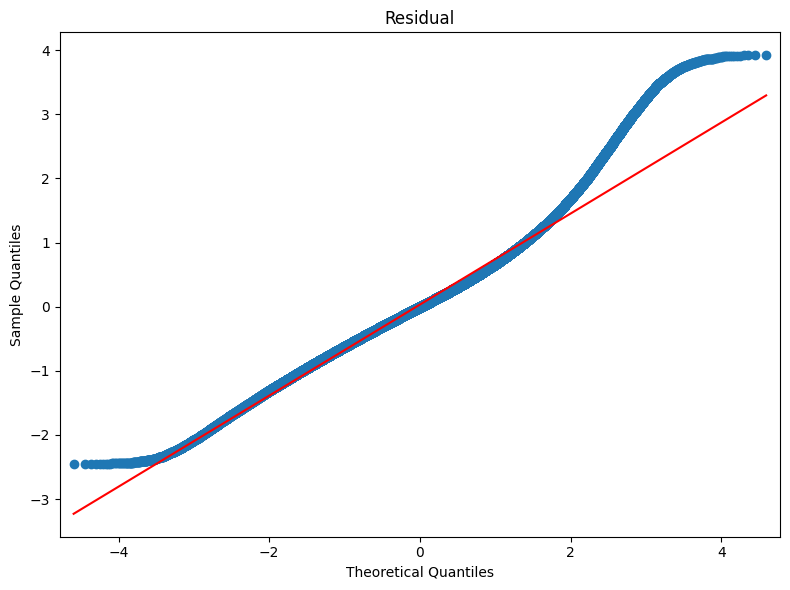

{'MAE': 0.5471501540598325,
 'RMSE': 0.7551902206518512,
 'MAPE': 310.63221369795406,
 'Adjusted R-squared': 0.6428558539652949,
 'Trimmed_MAE': 0.5398858081945379,
 'Residual Mean': 0.032238896769548844,
 'Residual Variance': 0.5146875253204135}

In [84]:
Pipeline_LSTM(train, test, sequence_length=3)

In [85]:
def Pipeline_LSTM_shift(train, test, sequence_length=10, validation_split=0.1, epochs=50, batch_size=1024, patience=10):
    """
    Pipeline to preprocess data, create sequences, train an LSTM model with early stopping, and compute evaluation metrics.

    Parameters:
        train (pd.DataFrame): Training dataset with features, "Ticker", and "Dollar_Volume".
        test (pd.DataFrame): Test dataset with features, "Ticker", and "Dollar_Volume".
        sequence_length (int): Number of past days to include in the sequence.
        validation_split (float): Fraction of the training data to use for validation (default is 0.2).
        epochs (int): Number of epochs for training (default is 50).
        batch_size (int): Batch size for training (default is 32).
        patience (int): Number of epochs to wait for improvement before stopping (default is 10).

    Returns:
        dict: Evaluation metrics from compute_metrics function.
    """
    set_random_seed()
    
    # Create sequences for train and test
    X_train, y_train = create_sequence_shift(train, sequence_length=sequence_length)
    X_test, y_test = create_sequence_shift(test, sequence_length=sequence_length)

    # Scale data
    scaler = StandardScaler()
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_split, shuffle=False)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Reshape data to 3D for LSTM: (samples, timesteps, features)
    X_train = X_train.reshape(-1, sequence_length, X_train.shape[-1] // sequence_length)
    X_val = X_val.reshape(-1, sequence_length, X_val.shape[-1] // sequence_length)
    X_test = X_test.reshape(-1, sequence_length, X_test.shape[-1] // sequence_length)

    # Define LSTM model
    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),  # Single LSTM layer
        Dropout(0.6),  # Regularization
        Dense(1)  # Output layer for regression
    ])
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['mae'])

    # Early stopping callback
    early_stop = EarlyStopping(
        monitor='val_loss',  # Monitor validation loss for early stopping
        patience=patience,   # Number of epochs with no improvement to stop training
        restore_best_weights=True  # Restore weights from the best epoch
    )

    # Train the model with early stopping
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    # Make predictions on the test set
    y_pred = model.predict(X_test)[:,-1]

    # Compute and return metrics
    return compute_metrics(y_pred.flatten(), y_test[:,-1])

Epoch 1/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.4470 - mae: 0.4470 - val_loss: 0.2965 - val_mae: 0.2965
Epoch 2/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.3730 - mae: 0.3730 - val_loss: 0.2939 - val_mae: 0.2939
Epoch 3/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.3713 - mae: 0.3713 - val_loss: 0.2950 - val_mae: 0.2950
Epoch 4/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.3708 - mae: 0.3708 - val_loss: 0.2963 - val_mae: 0.2963
Epoch 5/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.3703 - mae: 0.3703 - val_loss: 0.2923 - val_mae: 0.2923
Epoch 6/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.3702 - mae: 0.3702 - val_loss: 0.2920 - val_mae: 0.2920
Epoch 7/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.3700 - mae: 0.3700 - val_loss: 0.2930 - val_mae: 0.2930
Epoch 8/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.3699 - mae: 0.3699 - val_loss: 0.2921 - val_mae: 0.2921
Epoch 9/50
970/970 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - lo

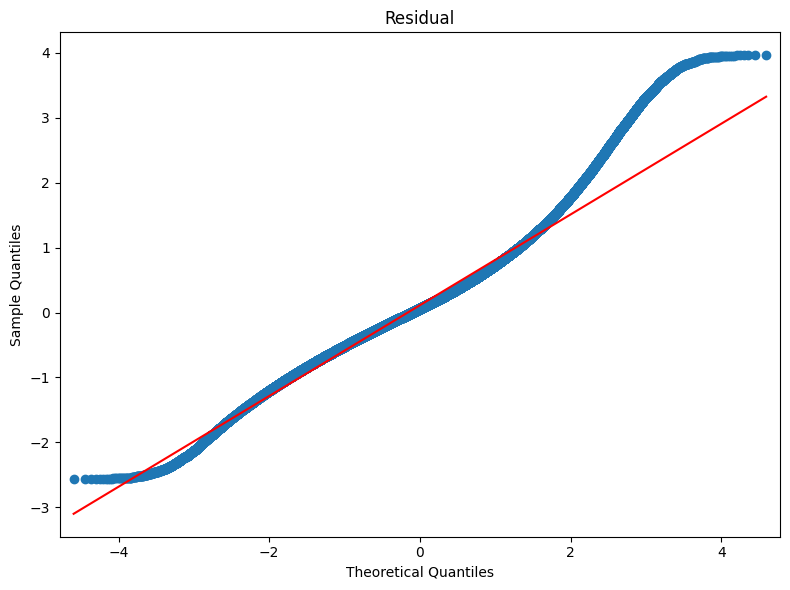

{'MAE': 0.5366447687520256,
 'RMSE': 0.7552354047065586,
 'MAPE': 292.9979720059066,
 'Adjusted R-squared': 0.6428131158499235,
 'Trimmed_MAE': 0.5292384850369175,
 'Residual Mean': 0.11271382136020752,
 'Residual Variance': 0.5026666562790971}

In [86]:
Pipeline_LSTM_shift(train, test, sequence_length = 3)

# ENSEMBLE STACKING

In [87]:
def Pipeline_ensemble_1(train, test, lasso, xgb_model, FFN, FFN_shift, FFN_shift_all, sequence_length = 3):
    
    
    X_train, y_train = create_sequence(train, sequence_length=sequence_length)
    X_test, y_test = create_sequence(test, sequence_length=sequence_length)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    lasso_fit = lasso.predict(X_train)
    lasso_pred = lasso.predict(X_test)

    FFN_fit = FFN.predict(X_train).flatten()
    FFN_pred = FFN.predict(X_test).flatten()

    xgb_fit = xgb_model.predict(xgb.DMatrix(X_train)).flatten()
    xgb_pred = xgb_model.predict(xgb.DMatrix(X_test)).flatten()
    
    X_train, y_train = create_sequence_shift(train, sequence_length=sequence_length)
    X_test, y_test = create_sequence_shift(test, sequence_length=sequence_length)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    FFN_shift_fit = FFN_shift.predict(X_train)[:,-1].flatten()
    FFN_shift_pred = FFN_shift.predict(X_test)[:,-1].flatten()
    
    X_train, y_train = create_sequence_shift_all(train, sequence_length=sequence_length)
    X_test, y_test = create_sequence_shift_all(test, sequence_length=sequence_length)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    FFN_shift_all_fit = FFN_shift_all.predict(X_train)[:,-1].flatten()
    FFN_shift_all_pred = FFN_shift_all.predict(X_test)[:,-1].flatten()
    
    
    X_fit = np.concatenate((lasso_fit.reshape(-1,1), xgb_fit.reshape(-1,1), FFN_fit.reshape(-1,1), FFN_shift_fit.reshape(-1,1), FFN_shift_all_fit.reshape(-1,1)), axis = 1)
    X_pred = np.concatenate((lasso_pred.reshape(-1,1), xgb_pred.reshape(-1,1), FFN_pred.reshape(-1,1), FFN_shift_pred.reshape(-1,1), FFN_shift_all_pred.reshape(-1,1)), axis = 1)
    
    lr = LinearRegression(positive=True)
    lr.fit(X_fit, y_train[:,-1].reshape(-1,1))
    ensemble_pred = lr.predict(X_pred).reshape(-1)
    
    return compute_metrics(ensemble_pred, y_test[:,-1])

34484/34484 ━━━━━━━━━━━━━━━━━━━━ 9s 256us/step
14529/14529 ━━━━━━━━━━━━━━━━━━━━ 4s 260us/step
34484/34484 ━━━━━━━━━━━━━━━━━━━━ 10s 278us/step
14529/14529 ━━━━━━━━━━━━━━━━━━━━ 4s 276us/step
34484/34484 ━━━━━━━━━━━━━━━━━━━━ 10s 302us/step
14529/14529 ━━━━━━━━━━━━━━━━━━━━ 4s 302us/step


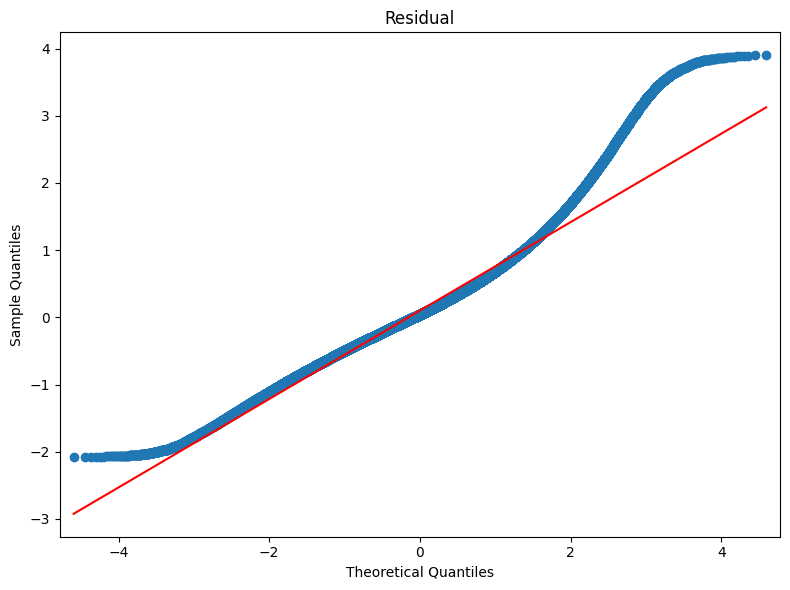

{'MAE': 0.5058546277307377,
 'RMSE': 0.7134810996537985,
 'MAPE': 266.30750956594034,
 'Adjusted R-squared': 0.6812165494782974,
 'Trimmed_MAE': 0.4990265095602141,
 'Residual Mean': 0.10026925287463843,
 'Residual Variance': 0.4476170876137498}

In [88]:
Pipeline_ensemble_1(train, test, lasso, xgb_model, FFN, FFN_shift, FFN_shift_all, sequence_length = 3)

In [89]:
def Pipeline_ensemble_2(train, test, lasso, FFN, FFN_shift, FFN_shift_all, sequence_length = 3):
    
    
    X_train, y_train = create_sequence(train, sequence_length=sequence_length)
    X_test, y_test = create_sequence(test, sequence_length=sequence_length)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    lasso_fit = lasso.predict(X_train)
    lasso_pred = lasso.predict(X_test)

    FFN_fit = FFN.predict(X_train).flatten()
    FFN_pred = FFN.predict(X_test).flatten()
    
    X_train, y_train = create_sequence_shift(train, sequence_length=sequence_length)
    X_test, y_test = create_sequence_shift(test, sequence_length=sequence_length)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    FFN_shift_fit = FFN_shift.predict(X_train)[:,-1].flatten()
    FFN_shift_pred = FFN_shift.predict(X_test)[:,-1].flatten()
    
    X_train, y_train = create_sequence_shift_all(train, sequence_length=sequence_length)
    X_test, y_test = create_sequence_shift_all(test, sequence_length=sequence_length)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    FFN_shift_all_fit = FFN_shift_all.predict(X_train)[:,-1].flatten()
    FFN_shift_all_pred = FFN_shift_all.predict(X_test)[:,-1].flatten()
    
    
    X_fit = np.concatenate((lasso_fit.reshape(-1,1), FFN_fit.reshape(-1,1), FFN_shift_fit.reshape(-1,1), FFN_shift_all_fit.reshape(-1,1)), axis = 1)
    X_pred = np.concatenate((lasso_pred.reshape(-1,1), FFN_pred.reshape(-1,1), FFN_shift_pred.reshape(-1,1), FFN_shift_all_pred.reshape(-1,1)), axis = 1)
    
    lr = LinearRegression(positive=True)
    lr.fit(X_fit, y_train[:,-1].reshape(-1,1))
    ensemble_pred = lr.predict(X_pred).reshape(-1)
    
    return compute_metrics(ensemble_pred+0.05, y_test[:,-1])

34484/34484 ━━━━━━━━━━━━━━━━━━━━ 9s 250us/step
14529/14529 ━━━━━━━━━━━━━━━━━━━━ 3s 239us/step
34484/34484 ━━━━━━━━━━━━━━━━━━━━ 10s 287us/step
14529/14529 ━━━━━━━━━━━━━━━━━━━━ 4s 290us/step
34484/34484 ━━━━━━━━━━━━━━━━━━━━ 11s 313us/step
14529/14529 ━━━━━━━━━━━━━━━━━━━━ 4s 293us/step


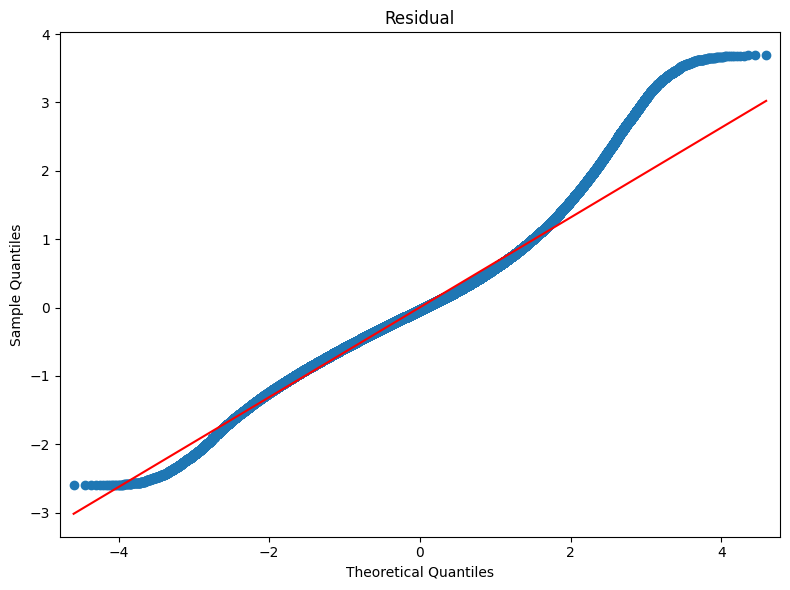

{'MAE': 0.5027307453652485,
 'RMSE': 0.7060574465621929,
 'MAPE': 296.6852610240389,
 'Adjusted R-squared': 0.6878158161773276,
 'Trimmed_MAE': 0.49538675074790917,
 'Residual Mean': 0.0037214537601831313,
 'Residual Variance': 0.443930084386134}

In [90]:
Pipeline_ensemble_2(train, test, lasso, FFN, FFN_shift, FFN_shift_all, sequence_length = 3)